In [2]:
import sys
import numpy as np
import pickle
# import pydot
import os
import time
from matplotlib import pyplot as plt 
import pandas as pd
import graphviz
import copy
import itertools
import multiprocessing as mp
from time import perf_counter
from queue import Queue
from queue import Empty
import networkx as nx
from networkx import write_multiline_adjlist, read_multiline_adjlist
# from networkx.drawing.nx_pydot import pydot_layout
from networkx.drawing.nx_agraph import graphviz_layout
from threading import Thread
from scipy.stats import pearsonr

# WARNING: This line is important for 3d plotting. DO NOT REMOVE
from mpl_toolkits.mplot3d import Axes3D

from sklearn import tree
from sklearn import decomposition
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import QuantileTransformer

In [3]:
os.chdir("/home/thlamp/tcga/python_results")

In [4]:
def progress(s):
    sys.stdout.write("%s" % (str(s)))
    sys.stdout.flush()


def message(s):
    sys.stdout.write("%s\n" % (str(s)))
    sys.stdout.flush()

In [5]:
global FEATURE_VECTOR_FILENAME
FEATURE_VECTOR_FILENAME = "/home/thlamp/tcga/bladder_results/raw_data_integrated_matrix.txt"

global Prefix
Prefix = ""

global THREADS_TO_USE
THREADS_TO_USE = mp.cpu_count()
#THREADS_TO_USE = 1

In [6]:
# global FEATURE_VECTOR_FILENAME
# FEATURE_VECTOR_FILENAME = "/home/thlamp/tcga/bladder_results/normalized_data_integrated_matrix.txt"
# global Prefix
# Prefix = ""

In [7]:
def initializeFeatureMatrices(bResetFiles=False, bPostProcessing=True, bNormalize=True,
                              bNormalizeLog2Scale=True):
    """
    Initializes the case/instance feature matrices, also creating intermediate files for faster startup.

    :param bResetFiles: If True, then reset/recalculate intermediate files. Default: False.
    :param bPostProcessing: If True, then apply post-processing to remove NaNs, etc. Default: True.
    :param bNormalize: If True, then apply normalization to the initial data. Default: True.
    :param bNormalizeLog2Scale: If True, then apply log2 scaling after normalization to the initial data. Default: True.
    :return: The initial feature matrix of the cases/instances.
    """

    message("Opening files...")

    try:
        if bResetFiles:
            raise Exception("User requested file reset...")
        message("Trying to load saved data...")

        # Apply np.load hack
        ###################
        # save np.load
        np_load_old = np.load ##return the input array from a disk file with npy extension(.npy)

        # modify the default parameters of np.load
        np.load = lambda *a, **k: np_load_old(*a, allow_pickle=True, **k)##lambda *a, **k: orizetai to lamda function and *a, **k function parameters
        ##np.load is a function provided by the NumPy library, typically used for loading data from saved files
        ## BUT np.load = ... assigns a new behavior to the np.load function. This assignment changes how the np.load function works for the duration of the current scope or context in which it's defined
        
        ##lambda *a, **k: defines an anonymous function (a lambda function) that takes any number of positional arguments as a tuple a and any number of keyword arguments as a dictionary k. This lambda function is like a wrapper around the original np.load function.
        ## call load_data with allow_pickle implicitly set to true
        
        ##allow_pickle=True: An additional keyword argument specifying that pickled objects are allowed to be loaded.
        
        datafile = np.load(Prefix + "patientAndControlData.mat.npy")
        labelfile = np.load(Prefix + "patientAndControlDataLabels.mat.npy")

        # restore np.load for future normal usage
        np.load = np_load_old ##orizei to np.load sthn default, arxikh leitourgia
        ####################

        clinicalfile = loadTumorStage()##epistrefei A matrix indicating the tumor stage per case/instance
        message("Trying to load saved data... Done.")
    except Exception as eCur:
        message("Trying to load saved data... Failed:\n%s" % (str(eCur)))
        message("Trying to load saved data from txt...")
        fControl = open(FEATURE_VECTOR_FILENAME, "r")
        message("Loading labels and ids...")
        # labelfile, should have stored tumor_stage or labels?       
        
        labelfile = np.genfromtxt(fControl, skip_header=1, usecols=(0, 100472),
                                  missing_values=['NA', "na", '-', '--', 'n/a'],
                                  dtype=np.dtype("object"), delimiter=' ').astype(str)
        ##numpy.genfromtxt function to read data from a file. This function is commonly used to load data from text files into a NumPy array.
        ##dtype=np.dtype("object"): This sets the data type for the resulting NumPy array to "object," which is a generic data type that can hold any type of data
        
        #+ removes " from first column 
        labelfile[:, 0] = np.char.replace(labelfile[:, 0], '"', '')

        fControl.close()
        
        message("This is the label file...")
        message(labelfile)
        
        message("Splitting features, this is the size of labelfile")
        message(np.shape(labelfile))

        message("Loading labels and ids... Done.")
        #---substitute loadTumorStage with clinicalfile = np.genfromtxt ...
        #clinicalfile = loadTumorStage()
        # Reset the file cursor to the beginning
        
        clinicalfile = loadTumorStage()
        
        

        datafile = loadPatientAndControlData()##return: the patient and control feature data file as a matrix
        message("Trying to load saved data from txt... Done.")

        # Saving
        saveLoadedData(datafile, labelfile)##Saves intermediate data and label file matrices for quick loading.

    message("Opening files... Done.")
	
    # Split feature set to features/target field
    mFeatures, vClass, sampleIDs = splitFeatures(clinicalfile, datafile, labelfile)##return: A tuple of the form (matrix of features, matrix of labels, sample ids)
    
    mControlFeatureMatrix = getControlFeatureMatrix(mFeatures, vClass)#return: The subset of the data matrix, reflecting only control cases/instances.
    message("1 .This is the shape of the control matrix:")
    message(np.shape(mControlFeatureMatrix))


    # the new bPostProcessing removes columns from mFeatures and mControlFeatureMatrix
    if bPostProcessing:
        # mFeatures = postProcessFeatures(mFeatures, mControlFeatureMatrix)
        ## for the updated postProcessFeatures
        mFeatures, sampleIDs, vClass, feat_names = postProcessFeatures(mFeatures, vClass, sampleIDs)
        ##return: The post-processed matrix, without NaNs.

    # Update control matrix, taking into account postprocessed data
    mControlFeatureMatrix = getControlFeatureMatrix(mFeatures, vClass)
    ##Update control matrix, taking into account postprocessed data, an exei tre3ei to bPostProcessing dn 8a exei NaNs

    message("2 .This is the shape of the control matrix:")
    message(np.shape(mControlFeatureMatrix))

    if bNormalize:
        mFeatures = normalizeDataByControl(mFeatures, mControlFeatureMatrix, bNormalizeLog2Scale)
        ##return: The normalized and - possibly - log scaled version of the input feature matrix.

    # return feat_names in the function with updated postProcessFeatures
    return mFeatures, vClass, sampleIDs, feat_names

In [8]:
def loadTumorStage():
    """
    Gets tumor stage data from clinical data file.
    :return: A matrix indicating the tumor stage per case/instance.
    """
    # Tumor stage
    message("Loading tumor stage...")
    fControl = open(FEATURE_VECTOR_FILENAME, "r")
    # While loading stage, also convert string to integer
    clinicalfile = np.genfromtxt(fControl, skip_header=1, usecols=(0, 100473),
                                  missing_values=['NA', "na", '-', '--', 'n/a'],
                                  dtype=np.dtype("object"), delimiter=' ').astype(str)
    ##np.genfromtxt: This is a NumPy function used to load data from text files, including delimited files. It's a flexible function that can handle a variety of file formats.
    ##dtype=np.dtype("object"): This specifies the data type for the loaded data. The data type is set to "object," which is a flexible data type that can hold a variety of data types, including strings.
    clinicalfile[:, 0] = np.char.replace(clinicalfile[:, 0], '"', '')
    fControl.close()
    message("Loading tumor stage... Done.")
    message("This is the clinical file...")
    message(clinicalfile)
    message("These are the dimensions of the clinical file")
    message(np.shape(clinicalfile))
    return clinicalfile

In [9]:
# def getFeatureNames():
#     """
#     :return: The list of feature names.
#     """
#     message("Loading feature names...")
#     fControl = open(FEATURE_VECTOR_FILENAME, "r")
#     # Assuming fMatrix is the file path
#     df = pd.read_csv(fControl, delimiter=' ')
    
#     # Extract the column names
#     column_names = df.columns

#     ## keep the column names except last two with tumor stage and labels
#     column_names = column_names[:-2]
#     print(column_names)
#     ##numpy.genfromtxt function to read data from a file. This function is commonly used to load data from text files into a NumPy array.
#     ##dtype=np.dtype("float"): This sets the data type for the resulting NumPy array to float
#     fControl.close()
#     message("Loading feature names... Done.")

#     return column_names

In [10]:
def getFeatureNames():
    """
    :return: The list of feature names.
    """
    message("Loading feature names...")
    # Read the first line from the file
    with open(FEATURE_VECTOR_FILENAME, 'r') as file:
        first_line = file.readline()
    
    # Separate the contents by space and store them in a list
    column_names = first_line.split()
    
    #Remove label and tumor stage
    column_names = column_names[:-2]
    
    # Remove double quotes from all elements in the list
    column_names = [element.replace('"', '') for element in column_names]
    message("Loading feature names... Done.")
    return column_names


In [11]:
def loadPatientAndControlData():
    """
    Loads and returns the serialized patient and control feature data file as a matrix.
    :return: the patient and control feature data file as a matrix
    """
    message("Loading features...")
    fControl = open(FEATURE_VECTOR_FILENAME, "r")
    datafile = np.genfromtxt(fControl, skip_header=1, usecols=range(1, 100472),
                             missing_values=['NA', "na", '-', '--', 'n/a'], delimiter=" ",
                             dtype=np.dtype("float")
                             )
    ##numpy.genfromtxt function to read data from a file. This function is commonly used to load data from text files into a NumPy array.
    ##dtype=np.dtype("float"): This sets the data type for the resulting NumPy array to float
    fControl.close()

    message("This is the datafile...")
    message(datafile)
    message("Loading features... Done.")
    return datafile

In [12]:
def saveLoadedData(datafile, labelfile):
    """
    Saves intermediate data and label file matrices for quick loading.
    :param datafile: The matrix containing the feature data.
    :param labelfile: The matrix containing the label data.
    """
    message("Saving data in dir..." + os.getcwd())
    np.save(Prefix + "patientAndControlData.mat.npy", datafile)
    np.save(Prefix + "patientAndControlDataLabels.mat.npy", labelfile)
    message("Saving data... Done.")

In [13]:
def splitFeatures(clinicalfile, datafile, labelfile): 
    """
    Extracts class and instance info, returning them as separate matrices, where rows correspond to the same
    case/instance.

    :param clinicalfile: The file with the clinical info.
    :param datafile: The matrix containing the full feature data from the corresponding file.
    :param labelfile: The matrix containing  the full label data from the corresponding file.
    :return: A tuple of the form (matrix of features, matrix of labels)
    Chris update: :return: A tuple of the form (matrix of features, matrix of labels, sample ids)
    """
    message("Splitting features...")
    message("Number of features: %d"%(np.size(datafile, 1)))
    message("This is the label file:")
    message(labelfile)
    message("This is the shape of the labelfile: %s" % (str(np.shape(labelfile))))
    mFeatures = datafile[:, :]##datafile = the patient and control feature data file as a matrix
    # Create matrix with extra column (to add tumor stage)

    # iFeatCount = np.shape(mFeaturesOnly)[1] + 1
    
    ##np.shape(mFeaturesOnly)[1] After getting the shape, you are accessing the second element of the tuple, which corresponds to the number of columns in the array
    ##number of columns + 1
    # DEBUG LINES
    message("Label file rows: %d\tFeature file rows: %d"%(np.shape(labelfile)[0], np.shape(mFeatures)[0]))
    #############

    # mFeatures = np.zeros((np.shape(mFeaturesOnly)[0], iFeatCount))
    # mFeatures[:, :-1] = mFeaturesOnly
    # mFeatures[:, iFeatCount - 1] = np.nan##last column of the NumPy array mFeatures to np.nan
    
    # #---
    # #tumorStageToInt = np.vectorize(convertTumorType)##Converts tumor stages to float numbers, based on an index of classes.
    # choicelist = clinicalfile[:, 1].astype(float)
    # ## clinicalfile[:, 1]: This code extracts the entire second column (column with index 1) from the NumPy array clinicalfile
    # ## choicelist contains the float number representations of tumor stages from the second column of clinicalfile    

    # ## replace 0 (missing values) in tumor stage with nan
    # choicelist = np.where(choicelist==0, np.nan, choicelist)

    # # For every row
    # for iCnt in range(np.shape(labelfile)[0]):
    #     condlist = clinicalfile[:, 0] == labelfile[iCnt, 0]##comparing the elements and storing the result in the condlist will be a Boolean array with True, false

    #     ## clinicalfile[:, 1]: This code extracts the entire second column (column with index 1) from the NumPy array clinicalfile
    #     ## choicelist contains the float number representations of tumor stages from the second column of clinicalfile
    #     # Update the last feature, by joining on ID
    #     mFeatures[iCnt, iFeatCount - 1] = np.select(condlist, choicelist)
        ##mFeatures[iCnt, iFeatCount - 1] iCnt is used as the row index and last column
        ##np.select will select values from choicelist based on the corresponding conditions in condlist
    vClass = labelfile[:, 1]
    sampleIDs = labelfile[:, 0]
    print("This is the vClass: ")
    print(vClass)
    # DEBUG LINES
    message("Found classes:\n%s" % (str(vClass)))
    message("Found sample IDs:\n%s" % (str(sampleIDs)))
    #############
    # DEBUG LINES
    # message("Found tumor types:\n%s" % (
    #     "\n".join(["%s:%s" % (x, y) for x, y in zip(labelfile[:, 0], mFeatures[:, iFeatCount - 1])])))
    #############
    message("Splitfeatures: This is the mFeatures...")
    message(mFeatures)
    message("Splitting features... Done.")

    return mFeatures, vClass, sampleIDs

In [14]:
# def splitFeatures(clinicalfile, datafile, labelfile): 
#     """
#     Extracts class and instance info, returning them as separate matrices, where rows correspond to the same
#     case/instance.

#     :param clinicalfile: The file with the clinical info.
#     :param datafile: The matrix containing the full feature data from the corresponding file.
#     :param labelfile: The matrix containing  the full label data from the corresponding file.
#     :return: A tuple of the form (matrix of features, matrix of labels)
#     Chris update: :return: A tuple of the form (matrix of features, matrix of labels, sample ids)
#     """
#     message("Splitting features...")
#     message("Number of features: %d"%(np.size(datafile, 1)))
#     message("This is the label file:")
#     message(labelfile)
#     message("This is the shape of the labelfile: %s" % (str(np.shape(labelfile))))
#     mFeaturesOnly = datafile[:, :]##datafile = the patient and control feature data file as a matrix
#     # Create matrix with extra column (to add tumor stage)

#     iFeatCount = np.shape(mFeaturesOnly)[1] + 1
    
#     ##np.shape(mFeaturesOnly)[1] After getting the shape, you are accessing the second element of the tuple, which corresponds to the number of columns in the array
#     ##number of columns + 1
#     # DEBUG LINES
#     message("Label file rows: %d\tFeature file rows: %d"%(np.shape(labelfile)[0], np.shape(mFeaturesOnly)[0]))
#     #############

#     mFeatures = np.zeros((np.shape(mFeaturesOnly)[0], iFeatCount))
#     mFeatures[:, :-1] = mFeaturesOnly
#     mFeatures[:, iFeatCount - 1] = np.nan##last column of the NumPy array mFeatures to np.nan
    
#     #---
#     #tumorStageToInt = np.vectorize(convertTumorType)##Converts tumor stages to float numbers, based on an index of classes.
#     choicelist = clinicalfile[:, 1].astype(float)
#     ## clinicalfile[:, 1]: This code extracts the entire second column (column with index 1) from the NumPy array clinicalfile
#     ## choicelist contains the float number representations of tumor stages from the second column of clinicalfile    

#     ## replace 0 (missing values) in tumor stage with nan
#     choicelist = np.where(choicelist==0, np.nan, choicelist)

#     # For every row
#     for iCnt in range(np.shape(labelfile)[0]):
#         condlist = clinicalfile[:, 0] == labelfile[iCnt, 0]##comparing the elements and storing the result in the condlist will be a Boolean array with True, false

#         ## clinicalfile[:, 1]: This code extracts the entire second column (column with index 1) from the NumPy array clinicalfile
#         ## choicelist contains the float number representations of tumor stages from the second column of clinicalfile
#         # Update the last feature, by joining on ID
#         mFeatures[iCnt, iFeatCount - 1] = np.select(condlist, choicelist)
#         ##mFeatures[iCnt, iFeatCount - 1] iCnt is used as the row index and last column
#         ##np.select will select values from choicelist based on the corresponding conditions in condlist
#     vClass = labelfile[:, 1]
#     sampleIDs = labelfile[:, 0]
#     print("This is the vClass: ")
#     print(vClass)
#     # DEBUG LINES
#     message("Found classes:\n%s" % (str(vClass)))
#     message("Found sample IDs:\n%s" % (str(sampleIDs)))
#     #############
#     # DEBUG LINES
#     # message("Found tumor types:\n%s" % (
#     #     "\n".join(["%s:%s" % (x, y) for x, y in zip(labelfile[:, 0], mFeatures[:, iFeatCount - 1])])))
#     #############
#     message("Splitfeatures: This is the mFeatures...")
#     message(mFeatures)
#     message("Splitting features... Done.")

#     return mFeatures, vClass, sampleIDs

In [15]:
# Find only the control samples
def getControlFeatureMatrix(mAllData, vLabels):
    """
    Gets the features of control samples only.
    :param mAllData: The full matrix of data (control plus tumor data).
    :param vLabels: The matrix of labels per case/instance.
    :return: The subset of the data matrix, reflecting only control cases/instances.
    """
    message("Finding only the control data...")
    choicelist = mAllData
    #--- condlist = isEqualToString(vLabels, 'Solid_Tissue_Normal')##epistrefei true, false se numpy array
    # 0 is the label for controls
    condlist = vLabels == "0"
    message("This is the control feature matrix:")
    print(choicelist[condlist])## ektupvnei osa einai true dld osa exoyn Solid_Tissue_Normal
    message("Data shape: %s" % (str(np.shape(choicelist[condlist]))))## epistrefei shape choicelist matrix
    message("Finding only the control data...Done")
    return choicelist[condlist]##epistrefei subset tou sunolikou matrix me mono osa exoun Solid_Tissue_Normal

In [16]:
def getNonControlFeatureMatrix(mAllData, vLabels):
    """
    Returns the subset of the feature matrix, corresponding to non-control (i.e. tumor) data.
    :param mAllData: The full feature matrix of case/instance data.
    :param vLabels: The label matrix, defining what instance is what type (control/tumor).
    :return: The subset of the feature matrix, corresponding to non-control (i.e. tumor) data
    """
    choicelist = mAllData
    condlist = vLabels == "1"
    return choicelist[condlist]

In [17]:
# def rows_with_only_NaN(mAllData, level_indices):
#     """
#     :param mAllData: The full feature matrix of case/instance data.
#     :param level_indices: The columns of the omic level to search
#     :return: The indices of the rows that don't have data at least in one level
#     """
#     # create empty array
#     indices_of_empty_rows = np.empty(0)
    
#     for omic_level in level_indices:
#         # Create a boolean mask indicating NaN values
#         nan_mask = np.isnan(mAllData[:, omic_level[0]:omic_level[1]])
    
#         # Use np.all along axis 1 to check if all values in each row are True (indicating NaN)
#         rows_with_nan = np.all(nan_mask, axis=1)
    
#         # Get the indices of rows with NaN
#         indices_of_rows_with_nan = np.where(rows_with_nan)[0]
        
#         indices_of_empty_rows = np.append(indices_of_empty_rows, indices_of_rows_with_nan)

#     indices_of_empty_rows = np.unique(indices_of_empty_rows).astype(int)
#     return indices_of_empty_rows

In [18]:
# def remove_incomplete_samples(mAllData, sample_ids, vClass):
#     """
#     :param mAllData: The full feature matrix of case/instance data.
#     :param sample_ids: A list with sample ids
#     :return: The feature matrix without incomplete samples and the remaining sample ids
#     """
    
#     message("Removing incomplete samples...")
#     omic_levels = omic_level_indices()

#     indices_to_remove = rows_with_only_NaN(mAllData, omic_levels)
    
#     # Create a boolean mask to identify rows to keep
#     mask = np.ones(mAllData.shape[0], dtype=bool)
#     mask[indices_to_remove] = False
    
#     # Use boolean indexing to get the resulting matrix without specified rows
#     mFeatures = mAllData[mask]
    
#     removed_sample_ids = np.take(sample_ids, indices_to_remove)
#     message("The sample ids that were remored are:"+str(removed_sample_ids))
    
#     updated_sample_ids = np.delete(sample_ids, indices_to_remove)
#     updated_vClass = np.delete(vClass, indices_to_remove)
    
#     message("Removing incomplete samples... Done")
#     return mFeatures, updated_sample_ids, updated_vClass

In [19]:
# def rows_filtering(input_matrix, sample_ids, vClass, nan_threshold=0.2):
#     """
#     It returns the filtered matrix for rows and an array with the index of the rows that were kept
#     """
#     message("Rows' filtering... Done")
#     ## length of row
#     rows_length = input_matrix.shape[1]
#     ## count nan per row
#     nan_per_row = count_nan_per_row(input_matrix)
#     ## compute the frequency of nan per row
#     nan_frequency  = nan_per_row / rows_length
#     ## return an array with boolean values, that show the rows with <=nan_threshold 
#     rows_to_keep = nan_frequency <= nan_threshold

#     # keep the sample_ids of the remaining rows 
#     updated_sample_ids = np.array(sample_ids)[rows_to_keep]

#     # keep the sample_ids of the remaining rows 
#     updated_vClass = np.array(vClass)[rows_to_keep]
    
#     ## filtering the matrix by rows_to_keep
#     input_matrix = input_matrix[rows_to_keep, :]
#     message("The size of the new matrix is:"+str(np.shape(input_matrix)))
#     message("Rows' filtering... Done")
#     return input_matrix, updated_sample_ids, updated_vClass

# def count_nan_per_row(input_matrix):
#     nan_count_per_column = np.sum(np.isnan(input_matrix), axis=1)
#     return nan_count_per_column

## NEW

In [20]:
def CheckRowsNaN(input_matrix, nan_threshold=0.2):
    """
    It returns the filtered matrix for rows and an array with the index of the rows that were kept
    """
    message("Rows' filtering... Done")
    ## length of row
    rows_length = input_matrix.shape[1]
    ## count nan per row
    nan_per_row = count_nan_per_row(input_matrix)
    ## compute the frequency of nan per row
    nan_frequency  = nan_per_row / rows_length
    ## return an array with boolean values, that show the rows with <=nan_threshold 
    rows_to_remove = nan_frequency > nan_threshold

    rows_to_remove = np.where(rows_to_remove)
    # Flatten the 2D array into a 1D array 
    rows_to_remove = np.ravel(rows_to_remove)
    # keep the sample_ids of the remaining rows 
    # updated_sample_ids = np.array(sample_ids)[rows_to_keep]

    # keep the sample_ids of the remaining rows 
    # updated_vClass = np.array(vClass)[rows_to_keep]
    
    ## filtering the matrix by rows_to_keep
    # input_matrix = input_matrix[rows_to_keep, :]
    # message("The size of the new matrix is:"+str(np.shape(input_matrix)))
    # message("Rows' filtering... Done")
    return rows_to_remove

def count_nan_per_row(input_matrix):
    nan_count_per_column = np.sum(np.isnan(input_matrix), axis=1)
    return nan_count_per_column

## NEW

In [21]:
def rows_with_only_NaN(mAllData, level_indices):
    """
    :param mAllData: The full feature matrix of case/instance data.
    :param level_indices: The columns of the omic level to search
    :return: The indices of the rows that don't have data at least in one level
    """
    # create empty array
    indices_of_empty_rows = np.empty(0)
    
    for omic_level in level_indices:
        # Create a boolean mask indicating NaN values
        nan_mask = np.isnan(mAllData[:, omic_level[0]:omic_level[1]])
    
        # Use np.all along axis 1 to check if all values in each row are True (indicating NaN)
        rows_with_nan = np.all(nan_mask, axis=1)
    
        # Get the indices of rows with NaN
        indices_of_rows_with_nan = np.where(rows_with_nan)[0]
        
        indices_of_empty_rows = np.append(indices_of_empty_rows, indices_of_rows_with_nan)

    indices_of_empty_rows = np.unique(indices_of_empty_rows).astype(int)
    return indices_of_empty_rows

# NEW

In [22]:
def CheckColsNaN(input_matrix,nan_threshold=0.2):
    """
    It returns the filtered matrix for columns and an array with the index of the columns that were kept
    """
    message("Columns' filtering... ")
    ## length of columns
    columns_length = input_matrix.shape[0]
    ## count nan per column
    nan_per_column = count_nan_per_column(input_matrix)
    ## compute the frequency of nan per column
    nan_frequency  = nan_per_column / columns_length
    ## return an array with boolean values, that show the columns with <=nan_threshold t
    columns_to_remove = nan_frequency > nan_threshold

    columns_to_remove = np.where(columns_to_remove)
    # Flatten the 2D array into a 1D array 
    columns_to_remove = np.ravel(columns_to_remove)
    # features = getFeatureNames()

    # # keep the feature names of the remaining columns 
    # updated_feature_names = np.array(features)[columns_to_keep]
    
    # ## filtering the matrix by columns_to_keep
    # input_matrix = input_matrix[:, columns_to_keep]
    # message("The size of the new matrix is:"+str(np.shape(input_matrix)))
    # message("Columns' filtering... Done")
    return columns_to_remove

def count_nan_per_column(input_matrix):
    nan_count_per_column = np.sum(np.isnan(input_matrix), axis=0)
    return nan_count_per_column

# NEW

In [23]:
def postProcessFeatures(mFeatures, vClass, sample_ids):
    """
    Post-processes feature matrix to replace NaNs with control instance feature mean values, and also to remove
    all-NaN columns.

    :param mFeatures: The matrix to pre-process.
    :param mControlFeatures: The subset of the input matrix that reflects control instances.
    :param sample_ids: A list with sample ids.
    :return: The post-processed matrix, without NaNs.
    """
    message("Replacing NaNs from feature set...")
    # DEBUG LINES
    message("Data shape before replacement: %s" % (str(np.shape(mFeatures))))
    #############

    # WARNING: Imputer also throws away columns it does not like
    # imputer = Imputer(strategy="mean", missing_values="NaN", verbose=1)
    # mFeatures_noNaNs = imputer.fit_transform(mFeatures)

    rows_to_remove = CheckRowsNaN(mFeatures)

    levels_indices = omic_level_indices()
    
    incomplete_samples = rows_with_only_NaN(mFeatures, levels_indices)
    
    samples_to_remove = np.concatenate((rows_to_remove, incomplete_samples))
    samples_to_remove = np.unique(samples_to_remove)
    
    features_to_remove = CheckColsNaN(mFeatures)
    
    # Remove samples from the matrix
    mFeatures = np.delete(mFeatures, samples_to_remove, axis=0)

    # Remove features from the matrix
    mFeatures = np.delete(mFeatures, features_to_remove, axis=1)

    # Create a boolean mask to keep elements not in the indices_to_remove array
    mask = np.ones(len(sample_ids), dtype=bool)
    mask[samples_to_remove] = False

    message("mask:"+str(np.shape(mask)))
    message("vClass:"+str(np.shape(vClass)))
    # Use the mask to filter the array
    filtered_sample_ids = sample_ids[mask]
    filtered_vClass = vClass[mask]

    features = getFeatureNames()
    # Create a new list without the elements at the specified indices
    filtered_features = [element for index, element in enumerate(features) if index not in features_to_remove]
    
    # mFeatures, sample_ids, filtered_vClass = remove_incomplete_samples(mFeatures, sample_ids, vClass)

    # mFeatures, filtered_feature_names = columns_filtering(mFeatures)

    # mFeatures, filtered_sample_ids, filtered_vClass = rows_filtering(input_matrix, sample_ids, filtered_vClass)
    message(mFeatures)
    mControlFeatures = getControlFeatureMatrix(mFeatures, filtered_vClass)
    
    # Extract means per control col
    # :-1 beccause the last column is about tunor stage
    mMeans = np.nanmean(mControlFeatures[:, :], axis=0)##calculate the mean of an array mControlFeatures along a specific axis
    # Find nans
    inds = np.where(np.isnan(mFeatures[:, :]))## Find nans
    # Do replacement
    mFeatures[inds] = np.take(mMeans, inds[1])## Do replacement

    message("Are there any NaNs after postProcessing?")
    message(np.any(np.isnan(mFeatures[:, :])))
    # DEBUG LINES
    message("Data shape after replacement: %s" % (str(np.shape(mFeatures))))
    #############

    # TODO: Check below
    # WARNING: If a control data feature was fully NaN, but the corresponding case data had only SOME NaN,
    # we would NOT successfully deal with the case data NaN, because there would be no mean to replace them by.

    #############
    message("Replacing NaNs from feature set... Done.")

    # Convert np array to panda dataframe
    arr = np.array(mFeatures)

    message("Removing features that have only NaN values...")
    # mask = np.all(np.isnan(mFeatures), axis=0)
	##mask variable will be a boolean array with True at the positions where all values in the corresponding columns of mFeatures are NaN, and False where there is at least one non-NaN value in that column
    # mFeatures = mFeatures[:, ~mask]
    ##remove columns from the mFeatures array where all values are NaN, based on the mask boolean array
    message("Number of features after removal: %s" % (str(np.shape(mFeatures))))
    # message(mFeatures)
    # message("Removing features that have only NaN values...Done")

    message("Are there any NaNs after postProcessing, except last column?")
    message(np.any(np.isnan(mFeatures[:, :])))

    message("This is mFeatures in postProcessing...")
    message(mFeatures)
    return mFeatures, filtered_sample_ids, filtered_vClass, filtered_features

In [24]:
# def columns_filtering(input_matrix,nan_threshold=0.2):
#     """
#     It returns the filtered matrix for columns and an array with the index of the columns that were kept
#     """
#     message("Columns' filtering... ")
#     ## length of columns
#     columns_length = input_matrix.shape[0]
#     ## count nan per column
#     nan_per_column = count_nan_per_column(input_matrix)
#     ## compute the frequency of nan per column
#     nan_frequency  = nan_per_column / columns_length
#     ## return an array with boolean values, that show the columns with <=nan_threshold t
#     columns_to_keep = nan_frequency <= nan_threshold
    
#     features = getFeatureNames()

#     # keep the feature names of the remaining columns 
#     updated_feature_names = np.array(features)[columns_to_keep]
    
#     ## filtering the matrix by columns_to_keep
#     input_matrix = input_matrix[:, columns_to_keep]
#     message("The size of the new matrix is:"+str(np.shape(input_matrix)))
#     message("Columns' filtering... Done")
#     return input_matrix,updated_feature_names

# def count_nan_per_column(input_matrix):
#     nan_count_per_column = np.sum(np.isnan(input_matrix), axis=0)
#     return nan_count_per_column

In [14]:
mRNA = data[:, :60660]
miRNA = data[:, 60660:62541]
methylation = data[:, 62541:]

NameError: name 'data' is not defined

In [ ]:
hist_for_cols(miRNA,"miRNA")
hist_for_rows(miRNA,"miRNA")

In [23]:
def hist_for_cols(data,level):
    freq = count_nan_per_column(data)
    # print(a)
    # Creating plot
    
    relative_freq = freq/np.shape(data)[0]
    # print(np.shape(data)[0])
    # print(b)
    # Creating plot
    fig = plt.figure(figsize =(10, 7))
    
    # Set the bins parameter to control the width of each column
    bins = np.arange(0, 1.1, 0.1)  # Adjust the range and step size as needed
    
    # Save the objects, in order to keep bars for bar_label
    counts, edges, bars = plt.hist(relative_freq, bins=bins) 
    ## plot labels over the bars
    plt.bar_label(bars)
    
    # Set x-axis limits (ensure minimum value is set to 0)
    plt.xlim(0, 1)
    
    # Set x-axis ticks every 0.1
    plt.xticks(np.arange(0, 1.1, 0.1))
    
    plt.title("Relative frequency histogram for features in "+level) 
    
    plt.xlabel('Relative frequency of NaN')
    plt.ylabel('Counts')
    # show plot
    plt.show()
    # fig.savefig(level+'relative_freq.png')

In [24]:
def hist_for_rows(data,level):
    freq = count_nan_per_row(data)
    # print(a)
    
    relative_freq = freq/np.shape(data)[1]
    # print(np.shape(data)[0])
    # print(b)
    # Creating plot
    fig = plt.figure(figsize =(10, 7))
    
    # Set the bins parameter to control the width of each column
    bins = np.arange(0, 1.1, 0.1)  # Adjust the range and step size as needed
    
    # Save the objects, in order to keep bars for bar_label
    counts, edges, bars = plt.hist(relative_freq, bins=bins) 
    ## plot labels over the bars
    plt.bar_label(bars)
    
    # Set x-axis limits (ensure minimum value is set to 0)
    plt.xlim(0, 1)
    
    # Set x-axis ticks every 0.1
    plt.xticks(np.arange(0, 1.1, 0.1))
    
    plt.title("Relative frequency histogram for patients in "+level) 

    plt.xlabel('Relative frequency of NaN')
    plt.ylabel('Counts')
    # show plot
    plt.show()
    # fig.savefig(level+'relative_freq_in_patients.png')

In [24]:
# def postProcessFeatures(mFeatures, mControlFeatures):
#     """
#     Post-processes feature matrix to replace NaNs with control instance feature mean values, and also to remove
#     all-NaN columns.

#     :param mFeatures: The matrix to pre-process.
#     :param mControlFeatures: The subset of the input matrix that reflects control instances.
#     :return: The post-processed matrix, without NaNs.
#     """
#     message("Replacing NaNs from feature set...")
#     # DEBUG LINES
#     message("Data shape before replacement: %s" % (str(np.shape(mFeatures))))
#     #############

#     # WARNING: Imputer also throws away columns it does not like
#     # imputer = Imputer(strategy="mean", missing_values="NaN", verbose=1)
#     # mFeatures_noNaNs = imputer.fit_transform(mFeatures)

#     # remove columns with only nan in control from all and control data 
#     mFeatures, mControlFeatures = remove_empty_cols_from_control(mFeatures, mControlFeatures)
    
#     # Extract means per control col
#     # :-1 beccause the last column is about tunor stage
#     mMeans = np.nanmean(mControlFeatures[:, :], axis=0)##calculate the mean of an array mControlFeatures along a specific axis
#     # Find nans
#     inds = np.where(np.isnan(mFeatures[:, :]))## Find nans
#     # Do replacement
#     mFeatures[inds] = np.take(mMeans, inds[1])## Do replacement

#     message("Are there any NaNs after postProcessing?")
#     message(np.any(np.isnan(mFeatures[:, :])))
#     # DEBUG LINES
#     message("Data shape after replacement: %s" % (str(np.shape(mFeatures))))
#     #############

#     # TODO: Check below
#     # WARNING: If a control data feature was fully NaN, but the corresponding case data had only SOME NaN,
#     # we would NOT successfully deal with the case data NaN, because there would be no mean to replace them by.

#     #############
#     message("Replacing NaNs from feature set... Done.")

#     # Convert np array to panda dataframe
#     arr = np.array(mFeatures)

#     message("Removing features that have only NaN values...")
#     # mask = np.all(np.isnan(mFeatures), axis=0)
# 	##mask variable will be a boolean array with True at the positions where all values in the corresponding columns of mFeatures are NaN, and False where there is at least one non-NaN value in that column
#     # mFeatures = mFeatures[:, ~mask]
#     ##remove columns from the mFeatures array where all values are NaN, based on the mask boolean array
#     message("Number of features after removal: %s" % (str(np.shape(mFeatures))))
#     # message(mFeatures)
#     # message("Removing features that have only NaN values...Done")

#     message("Are there any NaNs after postProcessing, except last column?")
#     message(np.any(np.isnan(mFeatures[:, :])))

#     message("This is mFeatures in postProcessing...")
#     message(mFeatures)
#     return mFeatures

# !!!!

In [25]:
# def postProcessFeatures(mFeatures, vClass, sample_ids):
#     """
#     Post-processes feature matrix to replace NaNs with control instance feature mean values, and also to remove
#     all-NaN columns.

#     :param mFeatures: The matrix to pre-process.
#     :param mControlFeatures: The subset of the input matrix that reflects control instances.
#     :param sample_ids: A list with sample ids.
#     :return: The post-processed matrix, without NaNs.
#     """
#     message("Replacing NaNs from feature set...")
#     # DEBUG LINES
#     message("Data shape before replacement: %s" % (str(np.shape(mFeatures))))
#     #############

#     # WARNING: Imputer also throws away columns it does not like
#     # imputer = Imputer(strategy="mean", missing_values="NaN", verbose=1)
#     # mFeatures_noNaNs = imputer.fit_transform(mFeatures)

#     mFeatures, sample_ids, filtered_vClass = remove_incomplete_samples(mFeatures, sample_ids, vClass)

#     mFeatures, filtered_feature_names = columns_filtering(mFeatures)

#     mFeatures, filtered_sample_ids, filtered_vClass = rows_filtering(input_matrix, sample_ids, filtered_vClass)
    
#     mControlFeatures = getControlFeatureMatrix(mFeatures, filtered_vClass)
    
#     # Extract means per control col
#     # :-1 beccause the last column is about tunor stage
#     mMeans = np.nanmean(mControlFeatures[:, :], axis=0)##calculate the mean of an array mControlFeatures along a specific axis
#     # Find nans
#     inds = np.where(np.isnan(mFeatures[:, :]))## Find nans
#     # Do replacement
#     mFeatures[inds] = np.take(mMeans, inds[1])## Do replacement

#     message("Are there any NaNs after postProcessing?")
#     message(np.any(np.isnan(mFeatures[:, :])))
#     # DEBUG LINES
#     message("Data shape after replacement: %s" % (str(np.shape(mFeatures))))
#     #############

#     # TODO: Check below
#     # WARNING: If a control data feature was fully NaN, but the corresponding case data had only SOME NaN,
#     # we would NOT successfully deal with the case data NaN, because there would be no mean to replace them by.

#     #############
#     message("Replacing NaNs from feature set... Done.")

#     # Convert np array to panda dataframe
#     arr = np.array(mFeatures)

#     message("Removing features that have only NaN values...")
#     # mask = np.all(np.isnan(mFeatures), axis=0)
# 	##mask variable will be a boolean array with True at the positions where all values in the corresponding columns of mFeatures are NaN, and False where there is at least one non-NaN value in that column
#     # mFeatures = mFeatures[:, ~mask]
#     ##remove columns from the mFeatures array where all values are NaN, based on the mask boolean array
#     message("Number of features after removal: %s" % (str(np.shape(mFeatures))))
#     # message(mFeatures)
#     # message("Removing features that have only NaN values...Done")

#     message("Are there any NaNs after postProcessing, except last column?")
#     message(np.any(np.isnan(mFeatures[:, :])))

#     message("This is mFeatures in postProcessing...")
#     message(mFeatures)
#     return mFeatures, sample_ids, filtered_feature_names, filtered_vClass

# NEW

In [25]:
def omic_level_indices():
    """
    Returns the columns corresponding to each omic level
    """
    feature_names = getFeatureNames()

    # Search for elements that start with "ENSG" and contain "."
    indices_of_mrna = np.where(np.core.defchararray.startswith(feature_names, "ENSG") & (np.core.defchararray.find(feature_names, ".") != -1))[0]
    
    # Search for elements that start with "hsa"
    indices_of_mirna = np.where(np.core.defchararray.startswith(feature_names, "hsa"))[0]
    
    # Search for elements that start with "ENSG" and do not contain "."
    indices_of_methylation = np.where(np.core.defchararray.startswith(feature_names, "ENSG") & (np.core.defchararray.find(feature_names, ".") == -1))[0]

    mrna = []
    mirna = []
    methylation = []

    mrna.append(indices_of_mrna[0])
    mrna.append(indices_of_mrna[0] + indices_of_mrna.shape[0])
    message("The columns for the mRNA level are:" + str(mrna))
    mirna.append(indices_of_mirna[0])
    mirna.append(indices_of_mirna[0] + indices_of_mirna.shape[0])
    message("The columns for the miRNA level are:" + str(mirna))
    methylation.append(indices_of_methylation[0])
    methylation.append(indices_of_methylation[0] + indices_of_methylation.shape[0])
    message("The columns for the DNA methylation level are:"+str(methylation))

    all_levels = []
    all_levels.append(mrna)
    all_levels.append(mirna)
    all_levels.append(methylation)
    return all_levels

In [26]:
# def omic_level_indices():
#     """
#     Returns the columns corresponding to each omic level
#     """
#     feature_names = getFeatureNames()

#     #search for elements that start with "ENSG" and also include "."
#     indices_of_mrna = [index for index, element in enumerate(test) if element.startswith("ENSG") and "." in element]
#     #search for elements that start with "hsa"
#     indices_of_mirna = [index for index, element in enumerate(test) if element.startswith("hsa") ]
#     #search for elements that start with "ENSG" and don't include "."
#     indices_of_methylation = [index for index, element in enumerate(test) if element.startswith("ENSG") and "." not in element]

#     mrna = []
#     mirna = []
#     methylation = []

#     mrna.append(indices_of_mrna[0])
#     mrna.append(indices_of_mrna[0] + len(indices_of_mrna))
#     message("The columns for the mRNA level are:"+str(mrna))
#     mirna.append(indices_of_mirna[0])
#     mirna.append(indices_of_mirna[0] + len(indices_of_mirna))
#     message("The columns for the miRNA level are:"+str(mirna))
#     methylation.append(indices_of_methylation[0])
#     methylation.append(indices_of_methylation[0] +len(indices_of_methylation))
#     message("The columns for the DNA methylation level are:"+str(methylation))

#     all_levels = []
#     all_levels.append(mrna)
#     all_levels.append(mirna)
#     all_levels.append(methylation)
#     return all_levels

## remove_empty_cols_from_control is only to run postProcessFeatures
## probably will be removed

In [27]:
# def remove_empty_cols_from_control(mFeatures, control_m):
#     ## it removes the columns that have only nan in control from all data and control data
#     # Check which elements are NaN for all the data
#     nan_mask_all = np.isnan(mFeatures)
    
#     # Check if all elements in each column are NaN
#     columns_with_nan_all = np.all(nan_mask_all, axis=0)
    
#     # Get the indices of columns with only NaN values
#     column_indices_all = np.where(columns_with_nan_all)[0]
    
#     print("Columns with only NaN values in all data:", len(column_indices_all))
    
#     # Check which elements are NaN for control data
#     nan_mask_control = np.isnan(control_m)
    
#     # Check if all elements in each column are NaN
#     columns_with_nan_control = np.all(nan_mask_control, axis=0)
    
#     # Get the indices of columns with only NaN values
#     column_indices_control = np.where(columns_with_nan_control)[0]
    
#     print("Columns with only NaN values in control matrix:", len(column_indices_control))
    
#     # find common columns with only nan between all data and cintrol 
#     common_cols = np.intersect1d(column_indices_all, column_indices_control)
#     print("The common elements are:", len(common_cols))
    
#     # find columns that have only nan in control but haven't in all data
#     diff_cols = np.setdiff1d(column_indices_control, column_indices_all)
#     print("The different elements are:", diff_cols)
    
#     diff_cols_matrix = mFeatures[:, diff_cols]
#     # print("The matrix with the columns from diff_cols:")
#     # print(diff_cols_matrix)
    
#     nan_diff_elements = count_nan_per_column(diff_cols_matrix)
#     print("The percentage of NaN in the different element: ", (nan_diff_elements/np.shape(diff_cols_matrix)[0])*100)


#     # Use boolean indexing to get the submatrix with columns removed
#     mFeatures = mFeatures[:, ~np.isin(np.arange(mFeatures.shape[1]), column_indices_control)]
#     control_m = control_m[:, ~np.isin(np.arange(control_m.shape[1]), column_indices_control)]
#     return mFeatures, control_m

In [28]:
def normalizeDataByControl(mFeaturesToNormalize, mControlData, logScale=True):
    """
    Calculates relative change per feature, transforming also to a log 2 norm/scale

    :param mFeaturesToNormalize: The matrix of features to normalize.
    :param mControlData: The control data sub-matrix.
    :param logScale: If True, log scaling will occur to the result. Default: True.
    :return: The normalized and - possibly - log scaled version of the input feature matrix.
    """
    message("Normalizing based on control set...")

    # Make a copy of the input matrix so that you do not make changes to the input matrix
    mFeaturesToNormalize = np.copy(mFeaturesToNormalize)
    
    ## np.nanmean for all the columns except the last one with tumor stage
    centroid = np.nanmean(mControlData[:, :], 0)
    ##centroid variable will contain an array of mean values for each column in mControlData, with NaN values ignored in the calculation
    
    ## keep for calculation all the columns except the last one with tumor stage
    mFeaturesForCalculation = mFeaturesToNormalize[:, :]
    
    # Using percentile change instead of ratio, to avoid lower bound problems
    NormalizedmFeatures = ((mFeaturesForCalculation - centroid) + 10e-8) / (centroid + 10e-8)
    ## Relative change apo diplwmatikh
    ##+ 10e-8 Adds a small constant value to avoid division by zero

    # DEBUG LINES
    message("Data shape before normalization: %s" % (str(np.shape(mFeaturesToNormalize))))

    ## insert the results to the first columns of the matrix and keep the last column with tumor stage  
    # mFeaturesToNormalize[:, :] = NormalizedmFeatures
    mOut = NormalizedmFeatures
    #############
    if logScale:
        mOut = np.log2(2.0 + mOut)  # Ascertain positive numbers
        ## base-2 logarithm transformation after adding 2.0 to each element
    # DEBUG LINES
    message("Data shape after normalization: %s" % (str(np.shape(mOut))))
    #############
    message("Normalizing based on control set... Done.")
    return mOut

In [29]:
def PCAOnControl():
    """
    Apply and visualize PCA on control data.
    """

    message("Opening file...")
    mFeatures_noNaNs, vClass, sampleIDs, feat_names = initializeFeatureMatrices(False, True)##return: The initial feature matrix of the cases/instances.
    mFeatures_noNaNs = getControlFeatureMatrix(mFeatures_noNaNs, vClass)##epistrefei subset tou sunolikou matrix me mono osa exoun Solid_Tissue_Normal
    message("Opening file... Done.")
    X, pca3DRes = getPCA(mFeatures_noNaNs, 3)##epistrefei transformed matrix X represents the data in a lower-dimensional space kai 
                                            ##pca3DRes einai pca object me to apotelesma ths pca me information about the PCA transformation, including the explained variance ratio
    fig = draw3DPCA(X, pca3DRes)## epistrefei to plot
    fig.savefig("controlPCA3D.pdf", bbox_inches='tight')##save to plot se PDF file

In [30]:
def PCAOnTumor():
    """
    Apply and visualize PCA on tumor data.
    """
    message("Opening file...")
    mFeatures_noNaNs, vClass, sampleIDs, feat_names = initializeFeatureMatrices(False, True)##return: The initial feature matrix of the cases/instances.
    mFeatures_noNaNs = getNonControlFeatureMatrix(mFeatures_noNaNs, vClass)##epistrefei subset tou sunolikou matrix me mono osa einai non control
    message("Opening file... Done.")
    X, pca3DRes = getPCA(mFeatures_noNaNs, 3)##epistrefei transformed matrix X represents the data in a lower-dimensional space kai 
                                            ##pca3DRes einai pca object me to apotelesma ths pca me information about the PCA transformation, including the explained variance ratio

    fig = draw3DPCA(X, pca3DRes)## epistrefei to plot

    fig.savefig("tumorPCA3D.pdf", bbox_inches='tight')##save to plot se PDF file

In [31]:
def getPCA(mFeatures_noNaNs, n_components=3):
    """
    Return the PCA outcome given an array of instances.

    :param mFeatures_noNaNs: The array to analyze.
    :param n_components: The target number of components.
    :return: The PCA transformation result as a matrix.
    """
    pca = decomposition.PCA(n_components)##specify number of components
    pca.fit(mFeatures_noNaNs)##calculates the principal components and their variance explained
    X = pca.transform(mFeatures_noNaNs)##transformed matrix X represents the data in a lower-dimensional space

    return X, pca##epistrefei transformed matrix X represents the data in a lower-dimensional space kai pca object pou exei specified number of components

In [32]:
def draw3DPCA(X, pca3DRes, c=None, cmap=plt.cm.gnuplot, spread=False):
    ##c: This argument allows for different classes to be color-coded in the scatter plot. It is an optional argument.
    ##cmap: The colormap to be used for coloring the data points
    ##spread: A boolean flag that, if set to True, applies the QuantileTransformer to spread out the data distribution. This can be useful for better visualization of the spread of data points in the plot.
    """
    Draw a 3D PCA given, allowing different classes coloring.
    """
    
    # Percentage of variance explained for each components
    message('explained variance ratio (first 3 components): %s'
            % str(pca3DRes.explained_variance_ratio_))##pca3DRes einai pca object me to apotelesma ths pca me information about the PCA transformation, including the explained variance ratio
   
    if spread:
        X = QuantileTransformer(output_distribution='uniform').fit_transform(X)##QuantileTransformer is a data transformation technique used for scaling and normalizing data. It transforms the data in such a way that the transformed values have a specific probability distribution, often a uniform distribution
       
    fig = plt.figure(figsize =(15, 15))
    plt.clf()##clears the current figure. It's often used to start with a fresh, empty canvas for the new plot
    ax = fig.add_subplot(111, projection='3d')##The 111 argument is shorthand for a single subplot in a 1x1 grid. The projection='3d' argument specifies that this is a 3D plot
    ax.scatter(X[:, 0], X[:, 1], X[:, 2], edgecolor='k', c=c, cmap=cmap, depthshade=False, s=100)## data points specified by the three arrays X[:, 0], X[:, 1], and X[:, 2] along the X, Y, and Z axes
    ax.set_xlabel("X coordinate (%4.2f)" % (pca3DRes.explained_variance_ratio_[0]), fontsize=20) ## set fontsize
    ax.set_ylabel("Y coordinate (%4.2f)" % (pca3DRes.explained_variance_ratio_[1]), fontsize=20)
    ax.set_zlabel("Z coordinate (%4.2f)" % (pca3DRes.explained_variance_ratio_[2]), fontsize=20)
    ax.set_xticklabels([])##remove tick labels
    ax.set_yticklabels([])##Tick marks are the small lines or points on an axis that help users read and interpret the data on the plot.
    ax.set_zticklabels([])

    fig.show()
    return fig## epistrefei to plot

In [33]:
def PCAOnAllData():
    """
    Applies and visualizes PCA on all data.
    """
    #!!!!!!!!!!!! einai gia command line
    bResetFiles = False
    # if len(sys.argv) > 1: ## checks if there are more than one command-line arguments
    #     if "-resetFiles" in sys.argv: ## checks if the string "-resetFiles" is present in the list of command-line arguments
    #         bResetFiles = True

    # Initialize feature matrices
    mFeatures_noNaNs, vClass, sampleIDs, feat_names = initializeFeatureMatrices(bResetFiles=bResetFiles, bPostProcessing=True)
    ##return: The initial feature matrix of the cases/instances.
    message("Applying PCA...")
    X, pca3D = getPCA(mFeatures_noNaNs, 3)

    # Spread
    message("Applying PCA... Done.")

    # Percentage of variance explained for each components
    message('explained variance ratio (first 3 components): %s'
            % str(pca3D.explained_variance_ratio_))

    message('3 components values: %s'
            % str(X))

    message("Plotting PCA graph...")
    # Assign colors
    aCategories, y = np.unique(vClass, return_inverse=True)
    ##aCategories contains the unique categories or labels from the original vClass array.
    ##y is an array of integers that represent the indices of the unique categories in aCategories. Each element in y corresponds to a category in vClass.

    draw3DPCA(X, pca3D, c=y / 2)
    # DEBUG LINES
    message("Returning categories: \n %s" % (str(aCategories)))
    message("Returning categorical vector: \n %s" % (str(y)))
    message("Plotting PCA graph... Done.")

In [34]:
def ClusterAllData():
    """
    Creates k-means-based clustering of the control and tumor data, visualizing the results in a PCA-based 3D space.
    """
    # Initialize feature matrices
    mFeatures_noNaNs, vClass, sampleIDs, feat_names = initializeFeatureMatrices(bResetFiles=False, bPostProcessing=True)
    ##return: The initial feature matrix of the cases/instances.
    message("Separating instances per class...")
    # Perform clustering, initializing the clusters with a control and a patient
    # Set starting points
    npaControlFeatures = getControlFeatureMatrix(mFeatures_noNaNs, vClass)##return: The subset of the data matrix, reflecting only control cases/instances.
    npaNonControlFeatures = getNonControlFeatureMatrix(mFeatures_noNaNs, vClass)##return: The subset of the feature matrix, corresponding to non-control (i.e. tumor) data

    npInitialCentroids = np.array([np.nanmedian(npaControlFeatures[:, :], 0),
                                   np.nanmedian(npaNonControlFeatures[:, :], 0)])
    ##np.nanmedian(array, axis=0) computes the median along each column (axis 0) of the given array, while ignoring NaN (Not-a-Number) values.
    message("Separating instances per class... Done.")

    message("Applying k-means...")
    # Perform clustering
    clusterer = KMeans(2, init=npInitialCentroids, n_init=1)
    ## K-means clustering, npInitialCentroids are the initial centroids that you previously calculated using the median values.
    ##2 specifies the number of clusters you want to create, n_init=1 sets the number of times the k-means algorithm will be run with different centroid seeds. In this case, it's only run once.
    y_pred = clusterer.fit_predict(mFeatures_noNaNs)
    ##fits the KMeans model to your data and predicts the cluster labels
    message("Applying k-means... Done.")

    message("Applying PCA for visualization...")
    X, pca3D = getPCA(mFeatures_noNaNs, 3)##epistrefei transformed matrix X represents the data in a lower-dimensional space kai pca object pou exei specified number of components
    # X = QuantileTransformer(output_distribution='uniform').fit_transform(X)

    message("Applying PCA for visualization... Done.")

    draw3DPCA(X, pca3D, c=y_pred)
    aCategories, y = np.unique(vClass, return_inverse=True)## np.unique(vClass, return_inverse=True) returns a tuple. The first element of the tuple (aCategories) contains the unique elements of vClass, and the second element (y) contains an integer array such that each element of vClass is replaced by its index in the unique set of elements.
    draw3DPCA(X, pca3D, c=y)
    ##Draw a 3D PCA given, allowing different classes coloring.
    message("Plotting... Done.")

    # Calculate performance (number/precent of misplaced controls, number/precent of misplaced tumor samples)

In [35]:
def classify(X, y):
    """
    Calculates and outputs the performance of classification, through 10-fold cross-valuation, given a set of feature vectors and a set of labels.
    :param X: The feature vector matrix.
    :param y: The labels.
    """
    classifier = DecisionTreeClassifier() ## Creates an instance of a Decision Tree classifier.
    scores = cross_val_score(classifier, X, y, cv=min(10, len(y))); ##Performs 10-fold cross-validation using the Decision Tree classifier. 
    ## The function calculates the average performance score over the 10 folds and also outputs the standard deviation of the scores
    ## (min(10, len(y))) is used as the number of folds to ensure a minimum of 10 folds if the dataset is smaller.
    message("Avg. Performanace: %4.2f (st. dev. %4.2f) \n %s" % (np.mean(scores), np.std(scores), str(scores)))

    # Output model
    classifier.fit(X, y)
    dot_data = tree.export_graphviz(classifier, out_file=None) ## Creates DOT-format data representing the structure of the trained Decision Tree.
    graph = graphviz.Source(dot_data) ## Creates a graph from the DOT-format data.
    graph.render("Rules") ## takes the DOT-format data of the Decision Tree, uses the 'dot' program internally (from Graphviz), 
    ## and generates an image file named "Rules" with an appropriate file extension (e.g., "Rules.png" or "Rules.pdf").

In [55]:
def getFeatureGraph(mAllData, saFeatures, dEdgeThreshold=0.30, bResetGraph=True, dMinDivergenceToKeep=np.log2(10e5)):
    """
    Returns the overall feature graph, indicating interconnections between features.

    :param mAllData: The matrix containing all case/instance data.
    :param dEdgeThreshold: The threshold of minimum correlation required to keep an edge.
    :param bResetGraph: If True, recompute correlations, else load from disc (if available). Default: True.
    :param dMinDivergenceToKeep: The threshold of deviation, indicating which features it makes sense to keep.
    Features with a deviation below this value are considered trivial. Default: log2(10e5).
    :return: The graph containing only useful features and their connections, indicating correlation.
    """
    try:
        if bResetGraph:
            raise Exception("User requested graph recreation.")

        message("Trying to load graph...")
        g = nx.Graph()
        g = read_multiline_adjlist(Prefix + "graphAdjacencyList.txt", create_using=g) ## reads the graph from a file using read_multiline_adjlist
        with open(Prefix + "usefulFeatureNames.pickle", "rb") as fIn: ## reads a list of useful feature names from a pickle file
            saUsefulFeatureNames = pickle.load(fIn)
        message("Trying to load graph... Done.")
        return g, saUsefulFeatureNames
    except Exception as e:
        message("Trying to load graph... Failed:\n%s\n Recomputing..." % (str(e)))

    # DEBUG LINES
    message("Got data of size %s." % (str(np.shape(mAllData))))
    message("Extracting graph...")
    #############
    # Init graph

    # Determine meaningful features (with a divergence of more than MIN_DIVERGENCE from the control mean)

    iFeatureCount = np.shape(mAllData)[1] ## the number of features in the input data mAllData
    mMeans = np.nanmean(mAllData, 0)  # Ignore nans ##computes the mean of each feature, ignoring NaN values.

    # DEBUG LINES
    message("Means: %s"%(str(mMeans)))
    dMeanDescribe = pd.DataFrame(mMeans)
    print(str(dMeanDescribe.describe()))
    #############
    
    # Q1 Chris: is this the step where we apply the threshold? What is the threshold?
    # So, basically keep in vUseful, only the features that their value is greater than dMinDivergenceToKeep
    vUseful = [abs(mMeans[iFieldNum]) > dMinDivergenceToKeep for iFieldNum in range(0, iFeatureCount)] ##boolean list indicating whether each feature's absolute deviation from the mean is greater than dMinDivergenceToKeep

    
    # saFeatures = getFeatureNames()[1:iFeatureCount] ## obtaining the names of the features in the dataset
    # REMOVED and take as input filtered features names from initializeFeatureMatrices
   
    saUsefulIndices = [iFieldNum for iFieldNum, _ in enumerate(saFeatures) if vUseful[iFieldNum]]
    ## enumerate(saFeatures): The enumerate function is used to iterate over the indices and values of saFeatures. It returns pairs of index and value for each element in saFeatures.
    ## for iFieldNum, _ in enumerate(saFeatures): This part of the list comprehension unpacks the index as iFieldNum and ignores the value (using the underscore _) since it's not needed in this context.
    ## final result is a list (saUsefulIndices) containing the indices of features that are considered "useful" based on the thresholding condition. 
    saUsefulFeatureNames = [saFeatures[iFieldNum] for iFieldNum in saUsefulIndices] 
    ## extracts the names of "useful" features based on the indices stored in saUsefulIndices and creates a new list containing these feature names (saUsefulFeatureNames)
    iUsefulFeatureCount = len(saUsefulIndices)
    message("Keeping %d features out of %d." % (len(saUsefulIndices), len(saFeatures)))
    ###############################

    g = nx.Graph()
    message("Adding nodes...")
    # Add a node for each feature
    lIndexedNames = enumerate(saFeatures)
    for idx in saUsefulIndices:
        # Only act on useful features
        g.add_node(saFeatures[idx], label=idx)
    message("Adding nodes... Done.")

    # Measure correlations
    iAllPairs = (iUsefulFeatureCount * iUsefulFeatureCount) * 0.5
    ## (iUsefulFeatureCount * iUsefulFeatureCount) calculates the total number of possible pairs of "useful" features
    ## Multiplying by 0.5 is equivalent to dividing by 2, which accounts for the fact that combinations are used (unordered pairs).
    message("Routing edge calculation for %d possible pairs..." % (iAllPairs))
    lCombinations = itertools.combinations(saUsefulIndices, 2)
    ## itertools.combinations generates all possible combinations of length 2 from the elements in saUsefulIndices.
    ## Each combination represents an unordered pair of indices, which will be used to calculate correlations between pairs of "useful" features.

    # Create queue and threads
    threads = []
    num_worker_threads = THREADS_TO_USE  # DONE: Use available processors
    ## THREADS_TO_USE likely represents the desired number of worker threads to use for parallel processing.
    qCombination = Queue(1000 * num_worker_threads)
    ##This creates a queue (qCombination) with a maximum size of 1000 * num_worker_threads. The queue is used to pass combinations of feature indices to the worker threads for processing.
    
    processes = [Thread(target=addEdgeAboveThreshold, args=(i, qCombination,)) for i in range(num_worker_threads)]
    ## This creates a list of Thread objects (processes), each corresponding to a worker thread.
    ## The target is set to the addEdgeAboveThreshold function, which is the function that will be executed in parallel.
    ## The args parameter is a tuple containing arguments to be passed to the addEdgeAboveThreshold function. In this case, it includes the thread index i and the queue qCombination
    for t in processes:
        t.daemon = True
        #t.setDaemon(True)
        ## This sets each thread in the processes list as a daemon thread. Daemon threads are background threads that are terminated when the main program finishes.
        t.start()
        ## This starts each thread in the processes list, initiating parallel execution of the addEdgeAboveThreshold function.

    # Feed tasks
    iCnt = 1
    dStartTime = perf_counter()
    for iFirstFeatIdx, iSecondFeatIdx in lCombinations:
        qCombination.put((iFirstFeatIdx, iSecondFeatIdx, g, mAllData, saFeatures, iFirstFeatIdx, iSecondFeatIdx,
                          iCnt, iAllPairs, dStartTime, dEdgeThreshold))
        ## This line puts a tuple containing various parameters onto the queue (qCombination)
        ##  this tuple encapsulates all the necessary information for a worker thread to calculate the correlation between two features, determine whether an edge should be added to the graph, and perform the task efficiently. 
        ## The worker threads will dequeue these tuples and execute the corresponding tasks in parallel.
        # Wait a while if we reached full queue
        if qCombination.full():
            message("So far routed %d tasks. Waiting on worker threads to provide more tasks..." % (iCnt))
            time.sleep(0.05)

        iCnt += 1
    message("Routing edge calculation for %d possible pairs... Done." % (iAllPairs))

    message("Waiting for completion...")
    qCombination.join()
    ## The qCombination.join() method is used to block the program execution until all tasks in the queue (qCombination) are done. It is typically used in a scenario where multiple threads are performing parallel tasks, 
    ## and the main program needs to wait for all threads to finish their work before proceeding.
    message("Total time (sec): %4.2f" % (perf_counter() - dStartTime))

    message("Creating edges for %d possible pairs... Done." % (iAllPairs))

    message("Extracting graph... Done.")

    message("Removing single nodes... Nodes before removal: %d" % (g.number_of_nodes()))
    toRemove = [curNode for curNode in g.nodes().keys() if len(g[curNode]) == 0]
    ## a list (toRemove) containing the nodes in the graph (g) that have no edges, meaning they are isolated nodes (nodes with degree zero). 
    ## The condition len(g[curNode]) == 0 checks if the node's degree is zero.
    while len(toRemove) > 0:
        g.remove_nodes_from(toRemove) ## This removes the nodes listed in toRemove from the graph g
        toRemove = [curNode for curNode in g.nodes().keys() if len(g[curNode]) == 0] ## After removal, it updates the toRemove list with the names of nodes that are still isolated.
        message("Nodes after removal step: %d" % (g.number_of_nodes()))
    message("Removing single nodes... Done. Nodes after removal: %d" % (g.number_of_nodes()))

    message("Saving graph...")
    write_multiline_adjlist(g, Prefix + "graphAdjacencyList.txt") ## save a file using write_multiline_adjlist
    with open(Prefix + "usefulFeatureNames.pickle", "wb") as fOut: ## This line opens a file named "usefulFeatureNames.pickle" in binary write mode ("wb"). The with statement is used to ensure that the file is properly closed after writing.
        pickle.dump(saUsefulFeatureNames, fOut) ## serialize the Python object saUsefulFeatureNames and write the serialized data to the file fOut. The object is serialized into a binary format suitable for storage or transmission.

    message("Saving graph... Done.")

    message("Trying to load graph... Done.")

    return g, saUsefulFeatureNames

In [37]:
def addEdgeAboveThreshold(i, qQueue):
    """
    Helper function for parallel execution. It adds an edge between two features in the overall feature correlation
    graph, if the correlation exceeds a given level. All parameters are provided via a task Queue.
    :param i: The number of the executing thread.
    :param qQueue: The Queue object containing related task info.
    """
    while True:## continuously retrieves tasks from a qQueue object until it encounters a None task
        # Get next feature index pair to handle
        params = qQueue.get()
        # If empty, stop
        if params is None:
            message("Reached and of queue... Stopping.")
            break
        ## unpacks the parameters received from the queue, including feature indices (iFirstFeatIdx and iSecondFeatIdx), a graph (g), the entire feature data matrix (mAllData), an array of feature names (saFeatures), counters, a start time, and a correlation threshold
        iFirstFeatIdx, iSecondFeatIdx, g, mAllData, saFeatures, iFirstFeatIdx, iSecondFeatIdx, iCnt, iAllPairs, dStartTime, dEdgeThreshold = params

        # DEBUG LINES
        ## provide information about the progress of the correlation calculations. This information includes a progress dot for every 1000 iterations and more detailed information for every 10000 iterations
        if iCnt != 0 and (iCnt % 1000 == 0):
            progress(".")
            if iCnt % 10000 == 0 and iCnt != 0:
                dNow = perf_counter()
                dRate = ((dNow - dStartTime) / iCnt)
                dRemaining = (iAllPairs - iCnt) * dRate
                message("%d (Estimated remaining (sec): %4.2f - Working at a rate of %4.2f pairs/sec)\n" % (
                    iCnt, dRemaining, 1.0 / dRate))

        iCnt += 1
        #############
        ## calculates the Pearson correlation coefficient (fCurCorr) between the selected feature columns (vFirstRepr and vSecondRepr) using the pearsonr function
        # Fetch feature columns and calculate pearson
        vFirstRepr = mAllData[:, iFirstFeatIdx]
        vSecondRepr = mAllData[:, iSecondFeatIdx]
        fCurCorr = pearsonr(vFirstRepr, vSecondRepr)[0]
        ## If the correlation is above the specified threshold (dEdgeThreshold), it adds an edge to the graph (g) connecting the corresponding features with a weight representing the rounded correlation coefficient
        # Add edge, if above threshold
        if fCurCorr > dEdgeThreshold:
            g.add_edge(saFeatures[iFirstFeatIdx], saFeatures[iSecondFeatIdx], weight=round(fCurCorr * 100) / 100)## dtrogg se 2 dekadika psifia

        # Update queue
        ## The function then updates the counters and signals that the task is done
        qQueue.task_done()

In [38]:
def drawAndSaveGraph(gToDraw, bShow=True, sPDFFileName="corrGraph.pdf", bSave = True):
    """
    Draws and displays a given graph using graphviz.

    :param gToDraw: The graph to draw.
    """
    # Calculate the size based on the number of edges (you can adjust this as needed)
    figure_size = (len(gToDraw.edges()) * 2, len(gToDraw.edges()) * 2)

    plt.figure(figsize=figure_size)
    plt.clf()

    pos = graphviz_layout(gToDraw, prog='dot')  # Compute the positions of the nodes in the graph

    try:
        dNodeLabels = {}
        # For each node
        for nCurNode in gToDraw.nodes():
            # Try to add weight
            dNodeLabels[nCurNode] = "%s (%4.2f)" % (str(nCurNode), gToDraw.nodes[nCurNode]['weight'])
    except KeyError:
        # Weights could not be added, use nodes as usual
        dNodeLabels = None

    nx.draw_networkx(gToDraw, pos, arrows=False, node_size=1200, node_color="blue", with_labels=True, labels=dNodeLabels, font_size=10)

    # Increase the margins to ensure labels are fully visible
    plt.margins(x=0.5, y=0.2)

    # nx.draw_networkx: Draws the nodes and edges of the graph using the specified positions (pos) and other parameters
    labels = nx.get_edge_attributes(gToDraw, 'weight')
    
    # Extract the 'weight' attribute from the edges of a NetworkX graph (gToDraw)
    nx.draw_networkx_edge_labels(gToDraw, pos, edge_labels=labels)
    # nx.draw_networkx_edge_labels: Draws labels for the edges, assuming there are 'weight' attributes associated with the edges
    
    
    if bSave:
        plt.savefig(sPDFFileName, bbox_inches='tight')## bbox_inches='tight': This parameter adjusts the bounding box around the saved figure. The argument 'tight' is used to minimize the whitespace around the actual content of the figure
        message("Saving graph to file... Done.")
    # figure is closed after calling plt.show(), so it goes after savefig
    if bShow:
        plt.show()
 

# old def

In [39]:
# def drawGraph(gToDraw, bShow=True):
#     """
#     Draws and displays a given graph using graphviz.

#     :param gToDraw: The graph to draw.
#     """
#     # Calculate the size based on the number of edges (you can adjust this as needed)
#     figure_size = (len(gToDraw.edges()) * 2, len(gToDraw.edges()) * 2)

#     plt.figure(figsize=figure_size)
#     plt.clf()

#     pos = graphviz_layout(gToDraw, prog='dot')  # Compute the positions of the nodes in the graph

#     try:
#         dNodeLabels = {}
#         # For each node
#         for nCurNode in gToDraw.nodes():
#             # Try to add weight
#             dNodeLabels[nCurNode] = "%s (%4.2f)" % (str(nCurNode), gToDraw.nodes[nCurNode]['weight'])
#     except KeyError:
#         # Weights could not be added, use nodes as usual
#         dNodeLabels = None

#     nx.draw_networkx(gToDraw, pos, arrows=False, node_size=1200, node_color="blue", with_labels=True, labels=dNodeLabels, font_size=10)

#     # Increase the margins to ensure labels are fully visible
#     plt.margins(x=0.5, y=0.2)

#     # nx.draw_networkx: Draws the nodes and edges of the graph using the specified positions (pos) and other parameters
#     labels = nx.get_edge_attributes(gToDraw, 'weight')
    
#     # Extract the 'weight' attribute from the edges of a NetworkX graph (gToDraw)
#     nx.draw_networkx_edge_labels(gToDraw, pos, edge_labels=labels)
    
#     # nx.draw_networkx_edge_labels: Draws labels for the edges, assuming there are 'weight' attributes associated with the edges
#     if bShow:
#         plt.show()



In [40]:
# def showAndSaveGraph(gToDraw, sPDFFileName="corrGraph.pdf",bShow = True, bSave = True ):
#     """
#     Draws and displays a given graph, also saving it to a given file.
#     :param gToDraw: The graph to draw and save.
#     :param sPDFFileName:  The output filename. Default: corrGraph.pdf.
#     """
    
#     if bShow:
#         message("Displaying graph...")
#         drawGraph(gToDraw, bShow)
#         message("Displaying graph... Done.")
#     else:
#         message("Ignoring graph display as requested...")

#     if bSave:
#         message("Saving graph to file...")
#         try:
#             if bSave:
#                 plt.savefig(sPDFFileName, bbox_inches='tight')## bbox_inches='tight': This parameter adjusts the bounding box around the saved figure. The argument 'tight' is used to minimize the whitespace around the actual content of the figure
#                 message("Saving graph to file... Done.")
#         except Exception as e:
#             print("Could not save file! Exception:\n%s\n"%(str(e)))
#             print("Continuing normally...")
#     else:
#         message("Ignoring graph saving as requested...")
        

In [41]:
def getGraphAndData(bResetGraph=False, dMinDivergenceToKeep=np.log2(10e6), dEdgeThreshold=0.3,
                    bResetFiles=False, bPostProcessing=True, bNormalize=True, bNormalizeLog2Scale=True): # TODO: dMinDivergenceToKeep: Add as parameter
    """
    Loads the feature correlation graph and all feature data.
    :param bResetGraph: If True, recalculate graph, else load from disc. Default: False.
    :param dMinDivergenceToKeep: The threshold of data deviation to consider a feature useful. Default: log2(10e6).
    :param dEdgeThreshold: The minimum correlation between features to consider the connection useful. Default: 0.3.
    :param bResetFiles: If True, clear initial feature matrix serialization and re-parse CSV file. Default: False.
    :param bPostProcessing: If True, apply preprocessing to remove NaNs, etc. Default: True.
    :param bNormalize: If True, apply normalization to remove NaNs, etc. Default: True.
    :param bNormalizeLog2Scale: If true, after normalization apply log2 scale to feature values.
    :return: A tuple of the form (feature correlation graph, all feature matrix, instance/case class matrix,
        important feature names list)
    CV update:
    :return: A tuple of the form (feature correlation graph, all feature matrix, instance/case class matrix,
        important feature names list, sample ids)
    """
    # Do mFeatures_noNaNs has all features? Have we applied a threshold to get here?
    mFeatures_noNaNs, vClass, sampleIDs, feat_names = initializeFeatureMatrices(bResetFiles=bResetFiles, bPostProcessing=bPostProcessing,
                                                         bNormalize=bNormalize, bNormalizeLog2Scale=bNormalizeLog2Scale)
    gToDraw, saRemainingFeatureNames = getFeatureGraph(mFeatures_noNaNs, feat_names, dEdgeThreshold=dEdgeThreshold, bResetGraph=bResetGraph, dMinDivergenceToKeep=dMinDivergenceToKeep)

    return gToDraw, mFeatures_noNaNs, vClass, saRemainingFeatureNames, sampleIDs, feat_names

In [57]:
gToDraw, mFeatures_noNaNs, vClass, saRemainingFeatureNames, sampleIDs, feat_names = getGraphAndData(bResetGraph=True, dMinDivergenceToKeep=np.log2(10e6), dEdgeThreshold=0.3,bResetFiles=False, bPostProcessing=True, bNormalize=True, bNormalizeLog2Scale=True)

Opening files...
Trying to load saved data...
Loading tumor stage...
Loading tumor stage... Done.
This is the clinical file...
[['TCGA-2F-A9KO-01A' '4']
 ['TCGA-2F-A9KP-01A' '4']
 ['TCGA-2F-A9KQ-01A' '3']
 ['TCGA-2F-A9KR-01A' '3']
 ['TCGA-2F-A9KT-01A' '2']
 ['TCGA-2F-A9KW-01A' '3']
 ['TCGA-4Z-AA7M-01A' '3']
 ['TCGA-4Z-AA7N-01A' '3']
 ['TCGA-4Z-AA7O-01A' '2']
 ['TCGA-4Z-AA7Q-01A' '3']
 ['TCGA-4Z-AA7R-01A' '4']
 ['TCGA-4Z-AA7S-01A' '3']
 ['TCGA-4Z-AA7W-01A' '2']
 ['TCGA-4Z-AA7Y-01A' '2']
 ['TCGA-4Z-AA80-01A' '2']
 ['TCGA-4Z-AA81-01A' '2']
 ['TCGA-4Z-AA82-01A' '4']
 ['TCGA-4Z-AA83-01A' '2']
 ['TCGA-4Z-AA84-01A' '4']
 ['TCGA-4Z-AA86-01A' '4']
 ['TCGA-4Z-AA87-01A' '3']
 ['TCGA-4Z-AA89-01A' '4']
 ['TCGA-5N-A9KI-01A' '3']
 ['TCGA-5N-A9KM-01A' '3']
 ['TCGA-BL-A0C8-01A' '1']
 ['TCGA-BL-A0C8-01A-1' '1']
 ['TCGA-BL-A0C8-01B' '1']
 ['TCGA-BL-A13I-01A' '3']
 ['TCGA-BL-A13I-01A-1' '3']
 ['TCGA-BL-A13I-01B' '3']
 ['TCGA-BL-A13J-01A' '4']
 ['TCGA-BL-A13J-01A-1' '4']
 ['TCGA-BL-A13J-01B' '4']
 ['TCGA-B

In [42]:
def getMeanDegreeCentrality(gGraph):
    """
    Returns the average of the degree centralities of the nodes of a given graph.
    :param gGraph: The given graph.
    :return: The mean of degree centralities.
    """
    mCentralities = list(nx.degree_centrality(gGraph).values())
    return np.mean(mCentralities)

In [43]:
def getGraphVector(gGraph):
    """
    Represents a given graph as a vector/matrix, where each feature represents a graph description metric.
    :param gGraph: The graph to represent.
    :return: The feature vector, consisting of: #edges,#nodes, mean node degree centrality, number of cliques,
    average node connectivity, mean pair-wise shortest paths of connected nodes.
    """
    # DEBUG LINES
    message("Extracting graph feature vector...")
    ## resulting feature vector includes various graph metrics (Number of Edges, Number of Nodes, 
    ## Mean Node Degree Centrality, Number of Cliques, Average Node Connectivity, Mean Pair-wise Shortest Paths of Connected Nodes
    ## A clique in a graph is a subset of nodes where every two distinct nodes are adjacent (connected by an edge). In other words, a clique is a fully connected subgraph.
    ## counts how many cliques exist in the given graph.
    mRes = np.asarray(
        [len(gGraph.edges()), len(gGraph.nodes()),
         np.mean(np.array(list(nx.algorithms.centrality.degree_alg.degree_centrality(gGraph).values()))),
         # Avg deg centrality
         
         #nx.algorithms.clique.graph_number_of_cliques(gGraph),
         nx.algorithms.clique.number_of_cliques(gGraph),
         
         # TODO: Shortest path does NOT work.; revisit if needed
         # nx.algorithms.shortest_paths.unweighted.all_pairs_shortest_path_length(gGraph),
         # getAvgShortestPath(gGraph)
         nx.algorithms.connectivity.connectivity.average_node_connectivity(gGraph),
         nx.average_shortest_path_length(gGraph)
         
         # old AvgShortestPath
         # np.mean([np.mean(list(x[1].values())) for x in
         #          list(nx.algorithms.shortest_paths.unweighted.all_pairs_shortest_path_length(gGraph))]),
         ]
    )
    # DEBUG LINES
    message("Extracting graph feature vector... Done.")

    return mRes

In [44]:
def getSampleGraphVectors(gMainGraph, mFeatures_noNaNs, saRemainingFeatureNames, sampleIDs, bResetFeatures=True,
                          numOfSelectedSamples=-1, bShowGraphs=True, bSaveGraphs=True):
    """
    Extracts the graph feature vectors of a given set of instances/cases.
    :param gMainGraph: The overall feature correlation graph.
    :param mFeatures_noNaNs: The (clean from NaNs) feature matrix of instances/cases.
    :param saRemainingFeatureNames: The list of useful feature names.
    :param bResetFeatures: If True, features will be re-calculated. Otherwise, they will be loaded from an intermediate
    file. Default: True.
    :param numOfSelectedSamples: Allows working on a subset of the data. If -1, then use all data. Else use the given
    number of instances (half of which are taken from the first instances in mFeatures_noNaNs, while half from the
    last ones). Default: -1 (i.e. all samples).
    :return: A matrix containing the graph feature vectors of the selected samples.
    """
    ##responsible for extracting graph feature vectors of a given set of instances or cases
    # Get all sample graph vectors
    try:
        message("Trying to load graph feature matrix...")
        if bResetFeatures:
            raise Exception("User requested rebuild of features.")
        with open(Prefix + "graphFeatures.pickle", "rb") as fIn:## Opens the file in binary read mode
            mGraphFeatures = pickle.load(fIn)
        message("Trying to load graph feature matrix... Done.")
    except Exception as e:
        message("Trying to load graph feature matrix... Failed:\n%s" % (str(e)))
        message("Computing graph feature matrix...")

        if (numOfSelectedSamples < 0): ## If numOfSelectedSamples is less than 0, it means that all samples should be used
            mSamplesSelected = mFeatures_noNaNs
        else:
            mSamplesSelected = np.concatenate((mFeatures_noNaNs[0:int(numOfSelectedSamples / 2)][:], ## Selects the first half of the samples, from index 0 to half of numOfSelectedSamples
                                               mFeatures_noNaNs[-int(numOfSelectedSamples / 2):][:]), axis=0) ##Selects the second half of the samples, from the negative index (counting from the end) equivalent to half of numOfSelectedSamples to the end.

        message("Extracted selected samples:\n" + str(mSamplesSelected[:][0:10]))
        # Extract vectors
        # TODO pass SampleID to generateAllSampleGraphFeatureVectors
        mGraphFeatures = generateAllSampleGraphFeatureVectors(gMainGraph, mSamplesSelected, saRemainingFeatureNames, sampleIDs, bShowGraphs, bSaveGraphs)
        ## This function is assumed to compute graph feature vectors for the selected samples
        message("Computing graph feature matrix... Done.")

        message("Saving graph feature matrix...")
        with open(Prefix + "graphFeatures.pickle", "wb") as fOut:
            pickle.dump(mGraphFeatures, fOut) ## Uses the pickle module to serialize (dump) the data from mGraphFeatures and write it to the opened file (fOut).
        message("Saving graph feature matrix... Done.")
    return mGraphFeatures

In [45]:
# def generateAllSampleGraphFeatureVectors(gMainGraph, mAllSamples, saRemainingFeatureNames, sampleIDs, feat_names, bShowGraphs, bSaveGraphs):
#     """
#     Generates graph feature vectors for all samples and returns them as a matrix.
#     :param gMainGraph: The generic graph of feature correlations.
#     :param mAllSamples: The samples to uniquely represent as graph feature vectors.
#     :param saRemainingFeatureNames: The useful features subset.
#     :return: A matrix representing the samples (rows), based on their graph representation.
#     """
#     ########################
#     # Create queue and threads
#     threads = []
#     num_worker_threads = THREADS_TO_USE ## number of threads to be used in parallel.
#     qTasks = Queue(10 * num_worker_threads) ## A queue used to distribute tasks to worker threads.
#     for i in range(num_worker_threads):
#         t = Thread(target=getSampleGraphFeatureVector, args=(i, qTasks,bShowGraphs, bSaveGraphs,))
#         ## It creates a new thread (t) with the target set to the getSampleGraphFeatureVector function. The args parameter passes arguments to the function. 
#         ## In this case, it passes the thread index i, a task queue qTasks, and two boolean values bShowGraphs and bSaveGraphs.
#         t.daemon = True ##  Daemon threads are background threads that automatically exit when the main program finishes
#         t.start() ## This starts the thread, and it will execute the getSampleGraphFeatureVector function concurrently

#     # Count instances
#     iAllCount = np.shape(mAllSamples)[0] ## The total number of samples

#     # Item iterator
#     iCnt = iter(range(1, iAllCount + 1)) ## provide a sequence of numbers that can be used to track the progress or count the iterations of a loop or process.
#     dStartTime = perf_counter()

#     # Init result list
#     lResList = []
#     # Add all items to queue
#     np.apply_along_axis( ##apply a function along an axis of a NumPy array (mAllSamples)
#         lambda mSample: qTasks.put((sampleIDs, lResList, gMainGraph, mSample, saRemainingFeatureNames, feat_names, next(iCnt), iAllCount,
#                                     dStartTime)), 1, mAllSamples)
#     ## next(iCnt): next value from the iterator iCnt, retrieving the current sample index or iteration count.
#     ## 1, indicating that the function will be applied to each row of the array.
#     message("Waiting for completion...")
#     qTasks.join() ## qTasks.join() is used to block the execution of the current thread until all tasks in the queue (qTasks) are completed
#     message("Total time (sec): %4.2f" % (perf_counter() - dStartTime))

#     return np.array(lResList)

In [46]:
def assignSampleValuesToGraphNodes(gGraph, mSample, saSampleFeatureNames, feat_names):
    """
    Assigns values/weights to nodes of a given graph (inplace), for a given sample.
    :param gGraph: The generic graph.
    :param mSample: The sample which will define the feature node values/weights.
    :param saSampleFeatureNames: The mapping between feature names and indices.
    """
    # For each node
    for nNode in gGraph.nodes():
        # Get corresponding feature idx in sample 
        ## i changed saSampleFeatureNames with feat_names in order to get the right index of the feature name in the matrix 
        iFeatIdx = feat_names.index(nNode)
        # Assign value of feature as node weight
        dVal = mSample[iFeatIdx]
        # Handle missing values as zero (i.e. non-important)
        if dVal == np.NAN:
            dVal = 0

        gGraph.nodes[nNode]['weight'] = dVal

In [47]:
def spreadingActivation(gGraph, iIterations=100, dPreservationPercent=0.5, bAbsoluteMass=False):
    """
    Applies spreading activation to a given graph.
    :param gGraph: The graph used to apply spreading activation.
    :param iIterations: The number of iterations for the spreading.
    :param dPreservationPercent: The preservation of mass from each node, during the spreading.
    :param bAbsoluteMass: If True, use absolute values of mass. Otherwise, also allow negative spreading.
    :return: The (inplace) updated graph.
    """
    message("Applying spreading activation...")
    #!!! In each iteration
    for iIterCnt in range(iIterations):
        #!!! For every node
        for nCurNode in gGraph.nodes():
            # Get max edge weight
            dWeights = np.asarray([gGraph[nCurNode][nNeighborNode]['weight'] for nNeighborNode in gGraph[nCurNode]])
            ## collects the weights of the edges between the nCurNode and its neighboring nodes. It does this by creating a list dWeights
            ##p.asarray(dWeights) converts this list of edge weights into a NumPy array
            dWeightSum = np.sum(dWeights)
            ##sum of the edge weights stored in the dWeights 
            # For every neighbor
            for nNeighborNode in gGraph[nCurNode]:##For each neighboring node nNeighborNode of the current node nCurNode
                # Get edge percantile weight
                dMassPercentageToMove = gGraph[nCurNode][nNeighborNode]['weight'] / dWeightSum
                
                ##represents the percentage of the total weight (dWeightSum) that the edge weight from nCurNode to nNeighborNode contributes
                try:
                    # Assign part of the weight to the neighbor
                    dMassToMove = (1.0 - dPreservationPercent) * gGraph.nodes[nCurNode][
                        'weight'] * dMassPercentageToMove
                    
                    ## calculates the amount of mass to transfer from the current node (nCurNode) to its neighboring node (nNeighborNode). 
                    ## It considers the preservation percentage (dPreservationPercent), ensuring that only a portion of the mass is transferred
                    
                    # Work with absolute numbers, if requested
                    
                    ##bAbsoluteMass is True or False, the mass is added to or subtracted from the neighboring node's weight. If the mass transfer is negative (i.e., bAbsoluteMassisFalse), it means that the neighboring node loses mass, and if it's positive, it gains mass
                    if bAbsoluteMass:##If it's True, it works with the absolute values of mass
                        gGraph.nodes[nNeighborNode]['weight'] = abs(gGraph.nodes[nNeighborNode]['weight']) + abs(
                            dMassToMove)
                    else:
                        ##if bAbsoluteMass is False, the mass is added to or subtracted from the neighboring node's weight. If the mass transfer is negative (i.e., bAbsoluteMassisFalse), it means that the neighboring node loses mass, and if it's positive, it gains mass
                        gGraph.nodes[nNeighborNode]['weight'] += dMassToMove
                ## If the neighboring node (nNeighborNode) has no weight assigned (KeyError), a warning message is displayed, and the weight is assigned a value of 0.
                except KeyError:
                    message("Warning: node %s has no weight assigned. Assigning 0." % (str(nCurNode)))
                    gGraph.nodes[nNeighborNode]['weight'] = 0

            # Reduce my weight equivalently
            gGraph.nodes[nCurNode]['weight'] *= dPreservationPercent
            ##reduce the weight of the current node (nCurNode) by a factor of dPreservationPercent. 
            ##This reduction is part of the spreading activation process to preserve a portion of the mass within the current node while distributing the rest to its neighboring nodes
            ##dPreservationPercent value determines how much mass is preserved, and the remainder is distributed
    message("Applying spreading activation... Done.")
    return gGraph

In [48]:
def testSpreadingActivation():
    """
    A harmless test of graph drawing and spreading activation effect.
    """
    g = nx.Graph()  # creates an empty undirected graph g

    # adds edges to the graph
    g.add_edge(1, 2, weight=0.5)
    g.add_edge(2, 3, weight=0.5)
    g.add_edge(3, 4, weight=0.5)
    g.add_edge(2, 6, weight=0.2)
    g.add_edge(5, 6, weight=0.8)

    for nNode in g.nodes():
        g.nodes[nNode]['weight'] = nNode * 10
        # assigns a 'weight' attribute to each node based on the node's value, node 1 has a weight of 10, node 2 has a weight of 20
    drawAndSaveGraph(g, bSave = False)

    spreadingActivation(g)  # return The (inplace) updated graph
    drawAndSaveGraph(g, bSave = False)
    return g

In [49]:
def filterGraphNodes(gMainGraph, dKeepRatio):
    """
    Filters elements of a given graph (inplace), keeping a ratio of the top nodes, when ordered
    descending based on weight/value.

    :param gMainGraph: The graph from which nodes will be removed/filtered.
    :param dKeepRatio: The ratio of nodes we want to keep (between 0.0 and 1.0).
    :return: The filtered graph.
    """
    # Get all weights
    mWeights = np.asarray([gMainGraph.nodes[curNode]['weight'] for curNode in gMainGraph.nodes().keys()])
    message("mWeights: "+str(mWeights))
    # DEBUG LINES
    message("Filtering nodes... Weights: %s"%(str(mWeights.shape)))
    # If empty weights (possibly because the threshold is too high
    if (mWeights.shape[0] == 0):
        # Update the user and continue
        message("WARNING: The graph is empty...")
        
    ##########
    # Find appropriate percentile
    ## (1.0 - dKeepRatio) * 100: This expression calculates the percentile below which you want to filter out nodes. 
    ## If dKeepRatio is 0.2, for example, then (1.0 - 0.2) * 100 equals 80, meaning you want to keep the top 80% of nodes based on their weights.
    dMinWeight = np.percentile(mWeights, (1.0 - dKeepRatio) * 100)
    # Select and remove nodes with lower value
    ## toRemove is a list of node names that have weights below dMinWeight and should be removed from the graph
    toRemove = [curNode for curNode in gMainGraph.nodes().keys() if gMainGraph.nodes[curNode]['weight'] < dMinWeight]
    gMainGraph.remove_nodes_from(toRemove)

    return gMainGraph

# New generateAllSampleGraphFeatureVectors

In [54]:
def generateAllSampleGraphFeatureVectors(gMainGraph, mAllSamples, saRemainingFeatureNames, sampleIDs, feat_names, bShowGraphs, bSaveGraphs):
    """
    Generates graph feature vectors for all samples and returns them as a matrix.
    :param gMainGraph: The generic graph of feature correlations.
    :param mAllSamples: The samples to uniquely represent as graph feature vectors.
    :param saRemainingFeatureNames: The useful features subset.
    :return: A matrix representing the samples (rows), based on their graph representation.
    """
    ########################
    # Create queue and threads
    threads = []
    num_worker_threads = THREADS_TO_USE ## number of threads to be used in parallel.
    qTasks = Queue(10 * num_worker_threads) ## A queue used to distribute tasks to worker threads.
    for i in range(num_worker_threads):
        t = Thread(target=getSampleGraphFeatureVector, args=(i, qTasks,bShowGraphs, bSaveGraphs,))
        ## It creates a new thread (t) with the target set to the getSampleGraphFeatureVector function. The args parameter passes arguments to the function. 
        ## In this case, it passes the thread index i, a task queue qTasks, and two boolean values bShowGraphs and bSaveGraphs.
        t.daemon = True ##  Daemon threads are background threads that automatically exit when the main program finishes
        t.start() ## This starts the thread, and it will execute the getSampleGraphFeatureVector function concurrently

    # Count instances
    iAllCount = np.shape(mAllSamples)[0] ## The total number of samples

    # Item iterator
    iCnt = iter(range(1, iAllCount + 1)) ## provide a sequence of numbers that can be used to track the progress or count the iterations of a loop or process.
    dStartTime = perf_counter()

    # Init result list
    lResList = []
    # Add all items to queue
    for idx in range (np.shape(mAllSamples)[0]):
        qTasks.put((sampleIDs[idx], lResList, gMainGraph, mAllSamples[idx, :], saRemainingFeatureNames, feat_names, next(iCnt), iAllCount, dStartTime))
    ## next(iCnt): next value from the iterator iCnt, retrieving the current sample index or iteration count.
    ## 1, indicating that the function will be applied to each row of the array.
    message("Waiting for completion...")
    t.join() ## t.join() is used to block the execution of the current thread until all tasks in the queue (qTasks) are completed
    message("Total time (sec): %4.2f" % (perf_counter() - dStartTime))

    return np.array(lResList)

In [31]:
test

array([[1, 2, 1.0, {'ENSG00000218281.1': 1, 'ENSG00000219159.4': 1}, 1.0,
        1.0],
       [1, 2, 1.0, {'ENSG00000218281.1': 1, 'ENSG00000219159.4': 1}, 1.0,
        1.0]], dtype=object)

['ENSG00000196289.7', 'ENSG00000218281.1', 'ENSG00000219159.4', 'ENSG00000241818.1', 'hsa-mir-4523']
Working on instance 1 of 2...
['ENSG00000196289.7', 'ENSG00000218281.1', 'ENSG00000219159.4', 'ENSG00000241818.1', 'hsa-mir-4523']
Working on instance 2 of 2...
Found no items... Waiting... (already waited 0 times)
Found no items... Waiting... (already waited 0 times)
Found no items... Waiting... (already waited 0 times)
Found no items... Waiting... (already waited 0 times)
Applying spreading activation...
Applying spreading activation...
Found no items... Waiting... (already waited 0 times)
Applying spreading activation... Done.
Found no items... Waiting... (already waited 0 times)
Waiting for completion...
Applying spreading activation... Done.
mWeights: [294.11764706 558.82352941 441.17647059 147.05882353  58.82352941]
Filtering nodes... Weights: (5,)
mWeights: [29.41176471 55.88235294 44.11764706 14.70588235  5.88235294]
Extracting graph feature vector...
Filtering nodes... Weights:

<Figure size 200x200 with 0 Axes>

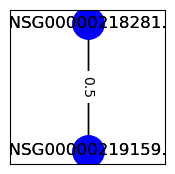

Calling drawAndSaveGraph...Done
Found no items... Waiting... (already waited 0 times)
Saving graph to file... Done.
Calling drawAndSaveGraph...Done
Found no items... Waiting... (already waited 0 times)
Found no items... Waiting... (already waited 1 times)
Found no items... Waiting... (already waited 1 times)
Found no items... Waiting... (already waited 1 times)
Found no items... Waiting... (already waited 1 times)
Found no items... Waiting... (already waited 1 times)
Found no items... Waiting... (already waited 1 times)
Found no items... Waiting... (already waited 1 times)
Found no items... Waiting... (already waited 1 times)
Found no items... Waiting... (already waited 2 times)
Found no items... Waiting... (already waited 2 times)
Found no items... Waiting... (already waited 2 times)
Found no items... Waiting... (already waited 2 times)
Found no items... Waiting... (already waited 2 times)
Found no items... Waiting... (already waited 2 times)
Found no items... Waiting... (already wait

In [110]:
test = generateAllSampleGraphFeatureVectors(g, mFeatures_noNaNs, saRemainingFeatureNames, sampleIDs, feat_names, bShowGraphs=True, bSaveGraphs=True)

# New drawAndSaveGraph

In [102]:
def drawAndSaveGraph(gToDraw, sPDFFileName="corrGraph.pdf",bShow = True, bSave = True):
    """
    Draws and displays a given graph, by using graphviz.

    :param gToDraw: The graph to draw.
    """
    figure_size = (len(gToDraw.edges()) * 2, len(gToDraw.edges()) * 2)

    plt.figure(figsize=figure_size)
    # plt.figure(figsize=(len(gToDraw.edges()) , len(gToDraw.edges())))## ru8mizei mege8os figure me bash ton ari8mo ton edges
    plt.clf()

    pos = graphviz_layout(gToDraw, prog='dot')
    
    try:
        dNodeLabels = {}
        # For each node
        for nCurNode in gToDraw.nodes():
            #!!! Try to add weight
            dNodeLabels[nCurNode] = "%s (%4.2f)" % (str(nCurNode), gToDraw.nodes[nCurNode]['weight'])
            
    except KeyError:
        # Weights could not be added, use nodes as usual
        dNodeLabels = None

    nx.draw_networkx(gToDraw, pos, arrows=False, node_size=1200, node_color="blue", with_labels=True, labels=dNodeLabels)
    ##nx.draw_networkx: Draws the nodes and edges of the graph using the specified positions (pos) and other parameters
    labels = nx.get_edge_attributes(gToDraw, 'weight')
    ##extract the 'weight' attribute from the edges of a NetworkX graph (gToDraw)
    nx.draw_networkx_edge_labels(gToDraw, pos, edge_labels=labels)
    ##nx.draw_networkx_edge_labels: Draws labels for the edges, assuming there are 'weight' attributes associated with the edges

    if bSave:
        message("Saving graph to file...")
        try:
            if bSave:
                # plt.savefig(sPDFFileName, bbox_inches='tight')## bbox_inches='tight': This parameter adjusts the bounding box around the saved figure. The argument 'tight' is used to minimize the whitespace around the actual content of the figure
                plt.savefig(sPDFFileName)
            message("Saving graph to file... Done.")
        except Exception as e:
            print("Could not save file! Exception:\n%s\n"%(str(e)))
            print("Continuing normally...")
    else:
        message("Ignoring graph saving as requested...")
    if bShow:
        plt.show()

## Example graph

In [83]:
g = nx.Graph()  # creates an empty undirected graph g

# adds edges to the graph
g.add_edge('ENSG00000196289.7','ENSG00000218281.1', weight=0.5)
g.add_edge('ENSG00000218281.1', 'ENSG00000219159.4', weight=0.5)
g.add_edge('ENSG00000219159.4', 'ENSG00000241818.1', weight=0.5)
g.add_edge('ENSG00000218281.1','hsa-mir-4523', weight=0.2)
# i=1

mFeatures_noNaNs = np.array([[10,20,30,40,50],[100,200,300,400,500]]) 
# drawAndSaveGraph(g, bShow = True, bSave = False)
saRemainingFeatureNames = np.array(['ENSG00000196289.7','ENSG00000218281.1','ENSG00000219159.4','ENSG00000241818.1','hsa-mir-4523'])
feat_names = ['ENSG00000196289.7','ENSG00000218281.1','ENSG00000219159.4','ENSG00000241818.1','hsa-mir-4523']
sampleIDs=np.array(["TCGA1","TCGA2"])

# num_worker_threads = THREADS_TO_USE ## number of threads to be used in parallel.
# qTasks = Queue() ## A queue used to distribute tasks to worker threads.

#     # Count instances
# iAllCount = np.shape(mFeatures_noNaNs)[0] ## The total number of samples

#     # Item iterator
# iCnt = iter(range(1, iAllCount + 1)) ## provide a sequence of numbers that can be used to track the progress or count the iterations of a loop or process.
# dStartTime = perf_counter()

#     # Init result list
# lResList = []
#     # Add all items to queue
# for idx in range (np.shape(mFeatures_noNaNs)[0]):
#     qTasks.put((sampleIDs[idx], lResList, g, mFeatures_noNaNs[idx, :], saRemainingFeatureNames, feat_names, next(iCnt), iAllCount))

# Test getSampleGraphFeatureVector

('TCGA1', [], <networkx.classes.graph.Graph object at 0x7fca9c31acc0>, array([10, 20, 30, 40, 50]), array(['ENSG00000196289.7', 'ENSG00000218281.1', 'ENSG00000219159.4',
       'ENSG00000241818.1', 'hsa-mir-4523'], dtype='<U17'), ['ENSG00000196289.7', 'ENSG00000218281.1', 'ENSG00000219159.4', 'ENSG00000241818.1', 'hsa-mir-4523'], 1, 2)
Working on instance 1 of 2...
Applying spreading activation...
Applying spreading activation... Done.
mWeights: [29.41176471 55.88235294 44.11764706 14.70588235  5.88235294]
Filtering nodes... Weights: (5,)
Extracting graph feature vector...
Extracting graph feature vector... Done.
Calling drawAndSaveGraph for graph TCGA1...
Saving graph to file...
Saving graph to file... Done.


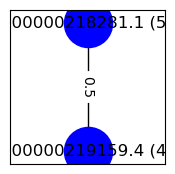

Calling drawAndSaveGraph...Done
('TCGA2', [array([1, 2, 1.0, {'ENSG00000218281.1': 1, 'ENSG00000219159.4': 1}, 1.0,
       1.0], dtype=object)], <networkx.classes.graph.Graph object at 0x7fca9c31acc0>, array([100, 200, 300, 400, 500]), array(['ENSG00000196289.7', 'ENSG00000218281.1', 'ENSG00000219159.4',
       'ENSG00000241818.1', 'hsa-mir-4523'], dtype='<U17'), ['ENSG00000196289.7', 'ENSG00000218281.1', 'ENSG00000219159.4', 'ENSG00000241818.1', 'hsa-mir-4523'], 2, 2)
Working on instance 2 of 2...
Applying spreading activation...
Applying spreading activation... Done.
mWeights: [294.11764706 558.82352941 441.17647059 147.05882353  58.82352941]
Filtering nodes... Weights: (5,)
Extracting graph feature vector...
Extracting graph feature vector... Done.
Calling drawAndSaveGraph for graph TCGA2...
Saving graph to file...
Saving graph to file... Done.


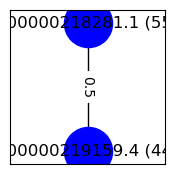

Calling drawAndSaveGraph...Done
Reached and of queue... Stopping.


In [183]:
getSampleGraphFeatureVector( qTasks, bShowGraphs=True, bSaveGraphs=True)

# New getSampleGraphFeatureVector

In [53]:
def getSampleGraphFeatureVector(i, qQueue, bShowGraphs=True, bSaveGraphs=True):
    """
    Helper parallelization function, which calculates the graph representation of a given sample.
    :param i: The thread number calling the helper.
    :param qQueue: A Queue, from which the execution data will be drawn. Should contain:
    lResList -- reference to the list containing the result
    gMainGraph -- the generic graph of feature correlations
    mSample -- the sample to represent
    saRemainingFeatureNames -- the list of useful feature names
    iCnt -- the current sample count
    iAllCount -- the number of all samples to be represented
    dStartTime -- the time when parallelization started
    """
    # dSample = {}

    iWaitingCnt = 0 # Number of tries, finding empty queue
    while True:
        try:
            params = qQueue.get_nowait()
        
        except Empty:
            if iWaitingCnt < 3:
                message("Found no items... Waiting... (already waited %d times)"%(iWaitingCnt))
                time.sleep(1)
                iWaitingCnt += 1 # Waited one more time
                continue
                 
            message("Waited long enough. Reached and of queue... Stopping.")
            break
        
        sampleID, lResList, gMainGraph, mSample, saRemainingFeatureNames, feat_names, iCnt, iAllCount, dStartTime = params
        print(feat_names)     
        # DEBUG LINES
        message("Working on instance %d of %d..." % (iCnt, iAllCount))
        #############

        # Create a copy of the graph
        gMainGraph = copy.deepcopy(gMainGraph)

        # Assign values    
        assignSampleValuesToGraphNodes(gMainGraph, mSample, saRemainingFeatureNames, feat_names)
        # Apply spreading activation
        gMainGraph = spreadingActivation(gMainGraph, bAbsoluteMass=True)  # TODO: Add parameter, if needed
        # Keep top performer nodes
        gMainGraph = filterGraphNodes(gMainGraph, dKeepRatio=0.25)  # TODO: Add parameter, if needed
        # Extract and return features
        vGraphFeatures = getGraphVector(gMainGraph)
        
        message("Calling drawAndSaveGraph for graph %s..."%(str(sampleID)))
        drawAndSaveGraph(gMainGraph, sPDFFileName = "SampleID%s.pdf" %(sampleID), bShow = bShowGraphs, bSave = bSaveGraphs)
        message("Calling drawAndSaveGraph...Done")
        #  Add to common result queue
        lResList.append(vGraphFeatures)

        # Signal done
        qQueue.task_done()##  It is typically used to indicate that a task previously retrieved from the queue has been completed.

        # DEBUG LINES
        if iCnt % 5 == 0 and (iCnt != 0):## progress update that is printed every 5 iterations of the loop
            dNow = perf_counter()
            dRate = ((dNow - dStartTime) / iCnt)
            dRemaining = (iAllCount - iCnt) * dRate
            message("%d (Estimated remaining (sec): %4.2f - Working at a rate of %4.2f samples/sec)\n" % (
                iCnt, dRemaining, 1.0 / dRate))